בס"ד

ב"ה

**M11 Practical Challenge: Decision Tree versus Random Forest Performance**

Ben Besthof, Tal Benhamou, Daniel Malinsky

DAV 6150

03/27/2024

**Introduction**

Objective of this assignment is to discover if decision trees or random forests best classifies a school's range of awarded regents diplomas.

While the performance of a random forest model is usually expected to be better than that of a single decision tree, there is an obvious complexity versus performance tradeoff we must assess when deciding whether to implement a single decision tree versus a random forest: random forests are much more computationally complex and generally more difficult to explain/interpret than are individual decision trees.

The dataset is sourced from the NY State Education Department (NYSED): https://data.nysed.gov/downloads.php.

The unit of analysis is a student subgroup in a school district for a given school year.

Feature selection will be based on correlation thresholds. If two features, for example, have a positive or negative correlation of 0.8 then the features will be considered for removal. The goal of feature selection is to reduce computational strain. Furtermore, variables with no variance, high , and low cardinality will be removed.

In [2]:
# Import required packages
!pip install regex
!pip install imblearn

import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import regex as re
import sklearn 
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score

# Load the dataset
df = pd.read_csv('https://raw.githubusercontent.com/Benhamax/DAV-6150---Data-Science/main/M11/M11_Data.csv')

# Display the DataFrame
df


,report_school_year,aggregation_index,aggregation_type,aggregation_name,nrc_code,nrc_desc,county_code,county_name,nyc_ind,membership_desc,subgroup_code,subgroup_name,enroll_cnt,grad_cnt,grad_pct,reg_cnt,reg_pct,dropout_cnt,dropout_pct
0,2018-19,3,District,ALBANY CITY SCHOOL DISTRICT,3,Urban-Suburban High Needs,1,ALBANY,0,2013 Total Cohort - 6 Year Outcome,1,All Students,658,464,71%,310,47%,148,22%
1,2018-19,3,District,ALBANY CITY SCHOOL DISTRICT,3,Urban-Suburban High Needs,1,ALBANY,0,2013 Total Cohort - 6 Year Outcome,2,Female,324,246,76%,169,52%,65,20%
2,2018-19,3,District,ALBANY CITY SCHOOL DISTRICT,3,Urban-Suburban High Needs,1,ALBANY,0,2013 Total Cohort - 6 Year Outcome,3,Male,334,218,65%,141,42%,83,25%
3,2018-19,3,District,ALBANY CITY SCHOOL DISTRICT,3,Urban-Suburban High Needs,1,ALBANY,0,2013 Total Cohort - 6 Year Outcome,4,American Indian/Alaska Native,-,-,-,-,-,-,-
4,2018-19,3,District,ALBANY CITY SCHOOL DISTRICT,3,Urban-Suburban High Needs,1,ALBANY,0,2013 Total Cohort - 6 Year Outcome,5,Black,367,248,68%,183,50%,91,25%
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73147,2018-19,3,District,DUNDEE CENTRAL SCHOOL DISTRICT,4,Rural High Needs,68,YATES,0,2013 Total Cohort - 6 Year Outcome - August 2019,18,Not Migrant,-,-,-,-,-,-,-
73148,2018-19,3,District,DUNDEE CENTRAL SCHOOL DISTRICT,4,Rural High Needs,68,YATES,0,2013 Total Cohort - 6 Year Outcome - August 2019,20,Homeless,-,-,-,-,-,-,-
73149,2018-19,3,District,DUNDEE CENTRAL SCHOOL DISTRICT,4,Rural High Needs,68,YATES,0,2013 Total Cohort - 6 Year Outcome - August 2019,21,Not Homeless,-,-,-,-,-,-,-
73150,2018-19,3,District,DUNDEE CENTRAL SCHOOL DISTRICT,4,Rural High Needs,68,YATES,0,2013 Total Cohort - 6 Year Outcome - August 2019,23,Not in Foster Care,-,-,-,-,-,-,-


**General Information of Data Set**

Checking data types, null count, columns and rows.

In [3]:
general = df.info()
general

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73152 entries, 0 to 73151
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   report_school_year  73152 non-null  object
 1   aggregation_index   73152 non-null  int64 
 2   aggregation_type    73152 non-null  object
 3   aggregation_name    73152 non-null  object
 4   nrc_code            73152 non-null  int64 
 5   nrc_desc            73152 non-null  object
 6   county_code         73152 non-null  int64 
 7   county_name         73152 non-null  object
 8   nyc_ind             73152 non-null  int64 
 9   membership_desc     73152 non-null  object
 10  subgroup_code       73152 non-null  int64 
 11  subgroup_name       73152 non-null  object
 12  enroll_cnt          73152 non-null  object
 13  grad_cnt            73152 non-null  object
 14  grad_pct            73152 non-null  object
 15  reg_cnt             73152 non-null  object
 16  reg_pct             73

Majority of variables are discrete numerical outcomes. And within the numerical variables most of them are count or percentage data. It is important to note that percentages and counts are being read as objects rather than floats and integers. The counts and rates variables need to be converted to numerical features so that models can interpret the data appropriately.

In [4]:
# List of variables to convert
convert_var = ['enroll_cnt',
 'grad_cnt',
 'grad_pct',
 'reg_cnt',
 'reg_pct',
 'dropout_cnt',
 'dropout_pct']


Duplicates Check

In [5]:

#creating object that sums duplicates
duplicated = df.duplicated().sum()

print('sum of duplicates', duplicated)

sum of duplicates 0


**Creating the target variable**


The target will be a categorical indicator variable derived from the dataset’s reg_pct attribute. This new
indicator variable will be comprised of three possible values:

A. “low”: indicates that the percentage of regents diplomas awarded for a given school district /
student subgrouping is less than ½ of the median percentage of all regent diplomas awarded (i.e.,
across all school district / student subgroupings);

B. “medium”: indicates that the percentage of regents diplomas awarded for a given school district /
student subgrouping is between 0.5 * the median percentage of all regent diplomas awarded (i.e.,
across all school district / student subgroupings) and 1.5 * the median percentage of all regent
diplomas awarded (i.e., across all school district / student subgroupings), i.e., (0.5 * median
percentage) < percentage of regents diplomas awarded for a given school district <= (1.5 * median
percentage)

C. “high”: indicates that the percentage of regents diplomas awarded for a given school district /
student subgrouping exceeds 1.5 * the median percentage of all regent diplomas awarded (i.e.,
across all school district / student subgroupings).

Values in all percentage columns need to be transformed into floats rather than keeping them as string values. Not only is this being done to help the models correctly interpret the data, but it will also help create the new variable. Regular expressions will be used to remove the percent character from all percentage columns and after the variables will be converted from string to float. 


In [6]:
#checking value counts in regents percentage column to inspect additional string characters.
df['reg_pct'].value_counts()

reg_pct
-      33478
50%     1528
44%     1210
40%     1190
43%     1189
       ...  
84%       25
87%       25
2%        15
3%        13
1%         4
Name: count, Length: 102, dtype: int64

Almost half of all records in the dataset contain value '-' which can be assumed to indicate a null value. In other words a significant proportion of instances contain missing values across numerical variables. 

In [7]:
###### creating a function that removes % characters, converts percentages from strings to floats, drops nulls, and creates target variable

def cleaning(df, columns):
    """removes % characters, converts percentages from strings to floats, converts counts to integers 

        Args:
            df : dataframe to be used
            columns: list of columns that need cleaning

        Returns: dataframe with no strings in percentage and count data    
    """
    #creating groups of variables: percentages and counts
    percentages = [i for i in columns if 'pct' in i]
    counts = [i for i in columns if i not in percentages]
    
    def fixing(dfcolumn):
        """ takes percentage characters out of percentage values

        Args:
            df : dataframe containing variables that need fixing 
        
        Returns: dataframe with clean values 
        """
        pattern = re.compile('%')
        clean = pattern.sub('', str(dfcolumn))
        return clean

    #need to apply fixing function to every percentage manually because df[percentages] has a list data type and the .astype() or .to_numeric() function will not apply to a list
    for i in percentages:
        df[i] = df[i].apply(fixing)
        df[i] = pd.to_numeric(df[i], errors = 'coerce')
        df.dropna(inplace = True)
        df.reset_index()
        df[i] = df[i]/100
    
    for i in counts:
        df[i] = pd.to_numeric(df[i], errors='coerce')
        df.dropna(inplace = True)
        df[i] = df[i].astype(int)
    
    #creating target variable
    df['reg_awd'] = df['reg_pct'].apply(lambda x: 2 if x > (1.5 * df['reg_pct'].median()) else(1 if x <= (1.5 * df['reg_pct'].median()) and x >= (0.5 * df['reg_pct'].median()) else 0))


    return df

df = cleaning(df, convert_var) 

df.head()

,report_school_year,aggregation_index,aggregation_type,aggregation_name,nrc_code,nrc_desc,county_code,county_name,nyc_ind,membership_desc,subgroup_code,subgroup_name,enroll_cnt,grad_cnt,grad_pct,reg_cnt,reg_pct,dropout_cnt,dropout_pct,reg_awd
0,2018-19,3,District,ALBANY CITY SCHOOL DISTRICT,3,Urban-Suburban High Needs,1,ALBANY,0,2013 Total Cohort - 6 Year Outcome,1,All Students,658,464,0.71,310,0.47,148,0.22,1
1,2018-19,3,District,ALBANY CITY SCHOOL DISTRICT,3,Urban-Suburban High Needs,1,ALBANY,0,2013 Total Cohort - 6 Year Outcome,2,Female,324,246,0.76,169,0.52,65,0.20,1
2,2018-19,3,District,ALBANY CITY SCHOOL DISTRICT,3,Urban-Suburban High Needs,1,ALBANY,0,2013 Total Cohort - 6 Year Outcome,3,Male,334,218,0.65,141,0.42,83,0.25,1
4,2018-19,3,District,ALBANY CITY SCHOOL DISTRICT,3,Urban-Suburban High Needs,1,ALBANY,0,2013 Total Cohort - 6 Year Outcome,5,Black,367,248,0.68,183,0.50,91,0.25,1
5,2018-19,3,District,ALBANY CITY SCHOOL DISTRICT,3,Urban-Suburban High Needs,1,ALBANY,0,2013 Total Cohort - 6 Year Outcome,6,Hispanic,98,58,0.59,40,0.41,28,0.29,1


The target variables has been created and recoded. 

0  = Low

1 = Medium 

2 = High

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39674 entries, 0 to 73146
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   report_school_year  39674 non-null  object 
 1   aggregation_index   39674 non-null  int64  
 2   aggregation_type    39674 non-null  object 
 3   aggregation_name    39674 non-null  object 
 4   nrc_code            39674 non-null  int64  
 5   nrc_desc            39674 non-null  object 
 6   county_code         39674 non-null  int64  
 7   county_name         39674 non-null  object 
 8   nyc_ind             39674 non-null  int64  
 9   membership_desc     39674 non-null  object 
 10  subgroup_code       39674 non-null  int64  
 11  subgroup_name       39674 non-null  object 
 12  enroll_cnt          39674 non-null  int64  
 13  grad_cnt            39674 non-null  int64  
 14  grad_pct            39674 non-null  float64
 15  reg_cnt             39674 non-null  int64  
 16  reg_pct  

We can take off the report_school_year variable because there is only a unique category which doesn't give any insight on the datset (No variance).

In [9]:
# dropping the report_school_year variable

df_copy = df.drop(columns=['report_school_year'])

In [10]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39674 entries, 0 to 73146
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   aggregation_index  39674 non-null  int64  
 1   aggregation_type   39674 non-null  object 
 2   aggregation_name   39674 non-null  object 
 3   nrc_code           39674 non-null  int64  
 4   nrc_desc           39674 non-null  object 
 5   county_code        39674 non-null  int64  
 6   county_name        39674 non-null  object 
 7   nyc_ind            39674 non-null  int64  
 8   membership_desc    39674 non-null  object 
 9   subgroup_code      39674 non-null  int64  
 10  subgroup_name      39674 non-null  object 
 11  enroll_cnt         39674 non-null  int64  
 12  grad_cnt           39674 non-null  int64  
 13  grad_pct           39674 non-null  float64
 14  reg_cnt            39674 non-null  int64  
 15  reg_pct            39674 non-null  float64
 16  dropout_cnt        39674 no

## Changing the datatype of somes variables.

We are checking which variable is in the rioght type so we can optimize our analysis


| #   | Column            | Non-Null Count | Current Dtype | Correct Dtype | Notes                                      | Classification |
|-----|-------------------|----------------|---------------|---------------|--------------------------------------------|----------------|
| 0   | aggregation_index | 39674          | int64         | object        | Likely categorical despite numeric format | Feature        |
| 1   | aggregation_type  | 39674          | object        | object        |                                            | Feature        |
| 2   | aggregation_name  | 39674          | object        | object        |                                            | Feature        |
| 3   | nrc_code          | 39674          | int64         | category      | Likely categorical despite numeric format  | Feature        |
| 4   | nrc_desc          | 39674          | object        | object        |                                            | Feature        |
| 5   | county_code       | 39674          | int64         | category      | Likely categorical despite numeric format  | Feature        |
| 6   | county_name       | 39674          | object        | object        |                                            | Feature        |
| 7   | nyc_ind           | 39674          | int64         | bool          | Convert to boolean (0 or 1)                | Feature        |
| 8   | membership_desc   | 39674          | object        | object        |                                            | Feature        |
| 9   | subgroup_code     | 39674          | int64         | category      | Likely categorical despite numeric format  | Feature        |
| 10  | subgroup_name     | 39674          | object        | object        |                                            | Feature        |
| 11  | enroll_cnt        | 39674          | int64         | int64         |                                            | Feature        |
| 12  | grad_cnt          | 39674          | int64         | int64         |                                            | Feature        |
| 13  | grad_pct          | 39674          | float64       | float64       |                                            | Feature        |
| 14  | reg_cnt           | 39674          | int64         | int64         |                                            | Feature        |
| 15  | reg_pct           | 39674          | float64       | float64       |                                            | Feature        |
| 16  | dropout_cnt       | 39674          | int64         | int64         |                                            | Feature        |
| 17  | dropout_pct       | 39674          | float64       | float64       |                                            | Feature        |
| 18  | reg_awd           | 39674          | object        | object        |                                            | Feature        |

The "Correct Dtype" suggestions are based on the assumption that the numeric codes (like `county_code`, `nrc_code`, etc.) are used for categorical purposes and not for calculation. For `nyc_ind`, if the values are only 0 and 1, it makes sense to use a boolean data type for memory efficiency and clarity.

### Converting the aggregation_index, nrc_code, county_code and the subgroup_code to the object format

(We also going to convert the nyc_ind to a categorical dtype for a short instance to check his vakues.)

In [11]:
# Code to convert the columns:
df_copy['aggregation_index'] = df_copy['aggregation_index'].astype('object')
df_copy['nrc_code'] = df_copy['nrc_code'].astype('object')
df_copy['county_code'] = df_copy['county_code'].astype('object')
df_copy['subgroup_code'] = df_copy['subgroup_code'].astype('object')
df_copy['nyc_ind'] = df_copy['nyc_ind'].astype('object')

# To check the changes, you can print the data types of each column
print(df_copy.dtypes)


aggregation_index     object
aggregation_type      object
aggregation_name      object
nrc_code              object
nrc_desc              object
county_code           object
county_name           object
nyc_ind               object
membership_desc       object
subgroup_code         object
subgroup_name         object
enroll_cnt             int64
grad_cnt               int64
grad_pct             float64
reg_cnt                int64
reg_pct              float64
dropout_cnt            int64
dropout_pct          float64
reg_awd                int64
dtype: object


Checking the values of nyc_ind before converting it in boolean

In [12]:
df_copy['nyc_ind'].describe()

count     39674
unique        2
top           0
freq      36292
Name: nyc_ind, dtype: int64

Now that we know that the value are 1 and 0 only, we are going to convert the dtype to boolean

In [13]:
# Convert to boolean
df_copy['nyc_ind'] = df_copy['nyc_ind'].astype('bool')

In [14]:
# To check the changes, you can print the data types of each column
print(df_copy.dtypes)

aggregation_index     object
aggregation_type      object
aggregation_name      object
nrc_code              object
nrc_desc              object
county_code           object
county_name           object
nyc_ind                 bool
membership_desc       object
subgroup_code         object
subgroup_name         object
enroll_cnt             int64
grad_cnt               int64
grad_pct             float64
reg_cnt                int64
reg_pct              float64
dropout_cnt            int64
dropout_pct          float64
reg_awd                int64
dtype: object


**Now that the values are in the rigfht format, we are going to use the describes function to each groups of Dtype (integer, float, object and boolean)**

#### Integer variable.

In [15]:
# Filter out the columns with integer dtype
int_columns = df_copy.select_dtypes(include=['int64']).columns

# Get the statistical summary for integer columns
df_copy[int_columns].describe()


,enroll_cnt,grad_cnt,reg_cnt,dropout_cnt,reg_awd
count,39674.000000,39674.000000,39674.000000,39674.000000,39674.000000
mean,192.120079,161.178354,86.804708,16.239225,0.989565
std,439.972474,361.294773,225.795826,50.129834,0.432226
min,5.000000,0.000000,0.000000,0.000000,0.000000
25%,25.000000,20.000000,10.000000,1.000000,1.000000
50%,66.000000,57.000000,27.000000,3.000000,1.000000
75%,179.000000,156.000000,69.000000,9.000000,1.000000
max,9176.000000,7540.000000,4752.000000,1091.000000,2.000000


Here's a quick summary for each column based on the statistical data provided:

- **enroll_cnt**: The average enrollment count is 192.12, with a substantial standard deviation of 439.97, indicating significant variability in the number of enrollments. The range of enrollments is quite broad, going from a minimum of 5 to a maximum of 9176.

- **grad_cnt**: On average, there are 161.18 graduates, with a standard deviation of 361.29, suggesting a wide dispersion in graduate counts across the dataset. While some counts are as low as zero, indicating no graduates, others reach as high as 7540.

- **reg_cnt**: The mean count of students receiving a 'Regents' diploma is 86.84, with considerable variation (std of 225.79). The counts range from none (0) to a peak of 4752, which reveals differences in Regents' diploma attainments.

- **dropout_cnt**: The dropout count has an average of 16.24 and a smaller standard deviation of 50.13 compared to other counts, showing less relative variability. Dropout counts span from 0 to 1091, pointing out that some institutions have a higher incidence of dropouts than others.

This data reflects the wide range of educational outcomes across different institutions or regions, with some showing very high numbers of enrollees, graduates, and Regents' diplomas, while others have notable numbers of dropouts.

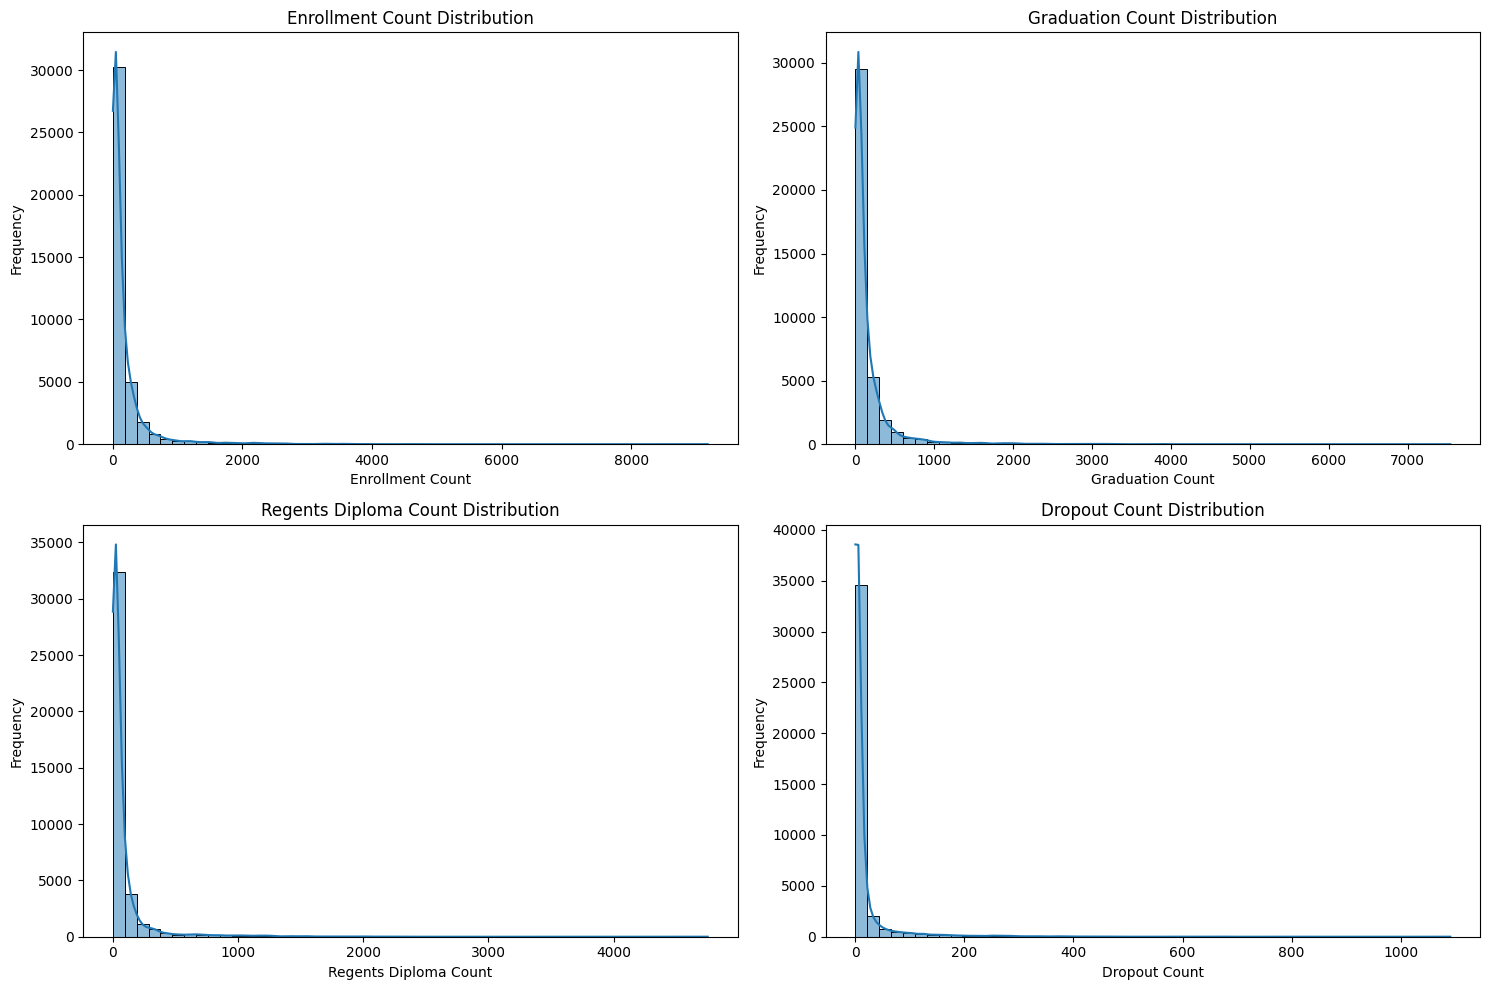

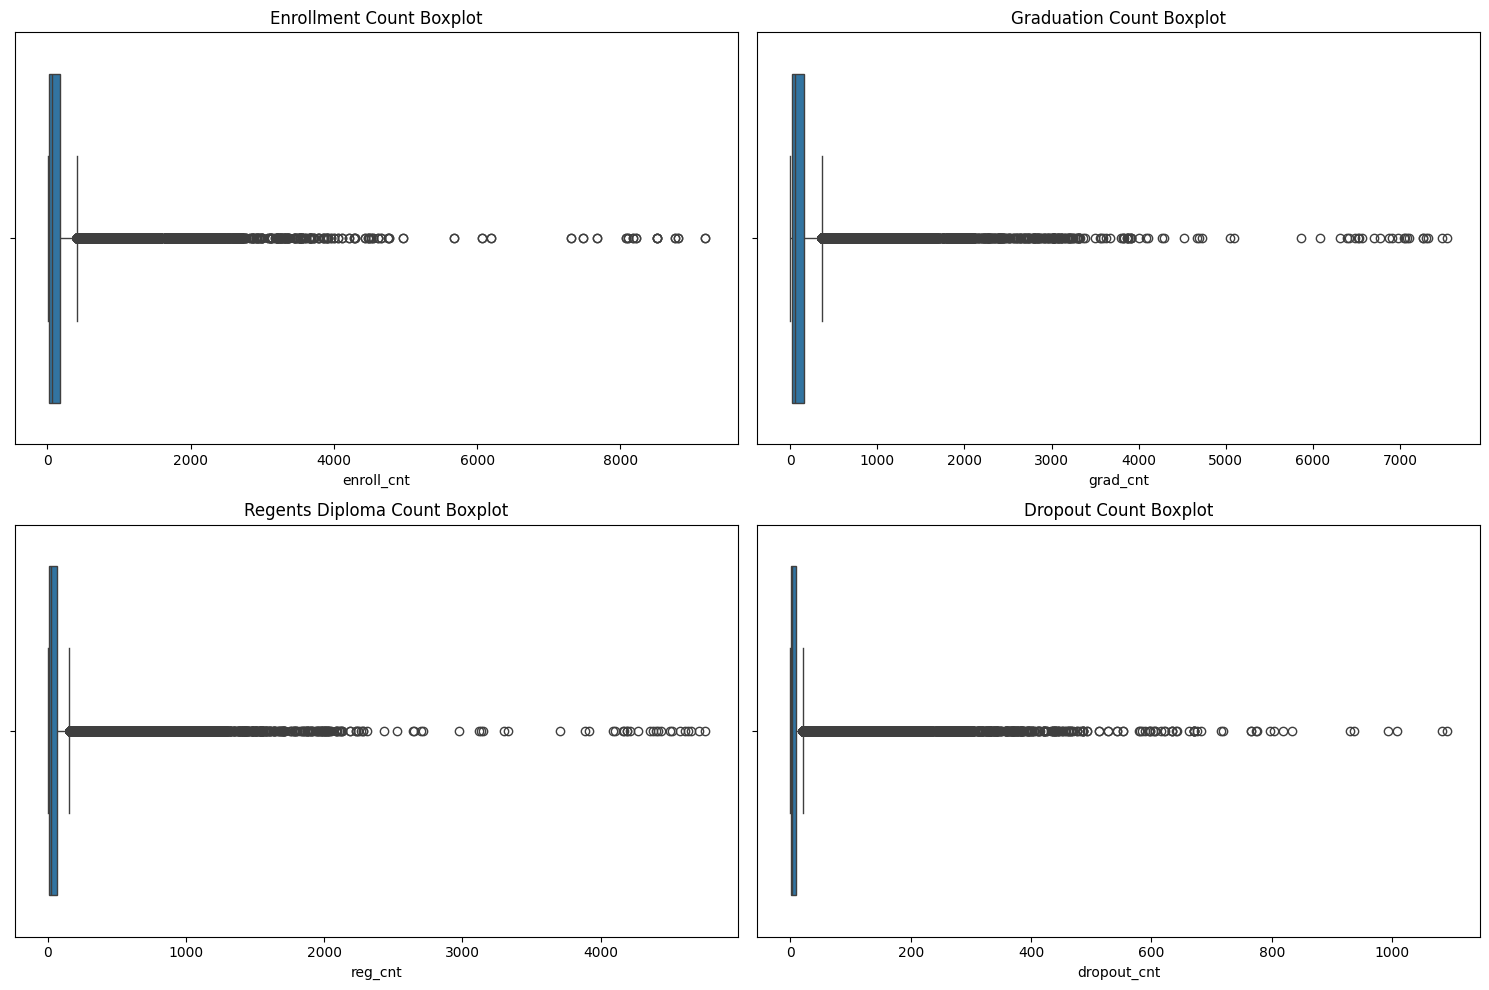

In [16]:
# Histograms for each variable
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Customize the individual plots if needed, here is a basic setup
sns.histplot(df_copy['enroll_cnt'], bins=50, kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Enrollment Count Distribution')
axes[0, 0].set_xlabel('Enrollment Count')
axes[0, 0].set_ylabel('Frequency')

sns.histplot(df_copy['grad_cnt'], bins=50, kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Graduation Count Distribution')
axes[0, 1].set_xlabel('Graduation Count')
axes[0, 1].set_ylabel('Frequency')

sns.histplot(df_copy['reg_cnt'], bins=50, kde=True, ax=axes[1, 0])
axes[1, 0].set_title('Regents Diploma Count Distribution')
axes[1, 0].set_xlabel('Regents Diploma Count')
axes[1, 0].set_ylabel('Frequency')

sns.histplot(df_copy['dropout_cnt'], bins=50, kde=True, ax=axes[1, 1])
axes[1, 1].set_title('Dropout Count Distribution')
axes[1, 1].set_xlabel('Dropout Count')
axes[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Box plots to show the range and outliers
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

sns.boxplot(x=df_copy['enroll_cnt'], ax=axes[0, 0])
axes[0, 0].set_title('Enrollment Count Boxplot')

sns.boxplot(x=df_copy['grad_cnt'], ax=axes[0, 1])
axes[0, 1].set_title('Graduation Count Boxplot')

sns.boxplot(x=df_copy['reg_cnt'], ax=axes[1, 0])
axes[1, 0].set_title('Regents Diploma Count Boxplot')

sns.boxplot(x=df_copy['dropout_cnt'], ax=axes[1, 1])
axes[1, 1].set_title('Dropout Count Boxplot')

plt.tight_layout()
plt.show()

The plots provide some valuable insights into the distribution of counts for enrollments, graduations, Regents diplomas, and dropouts.

From the histogram plots:

1. **Enrollment Count Distribution**: The enrollment counts are highly skewed, with most data points clustering at the lower end of the scale and a long tail extending towards higher counts. This indicates that while the majority of institutions or groups have relatively low enrollment numbers, a few have very high enrollments.

2. **Graduation Count Distribution**: Similar to the enrollment counts, graduation counts are also skewed, with a majority of the data points on the lower side. The distribution suggests that most institutions have fewer graduates, with only a handful having a very high number of graduates.

3. **Regents Diploma Count Distribution**: This histogram shows a highly skewed distribution of Regents diploma counts with the majority of institutions awarding a small number of diplomas, and few institutions awarding many more.

4. **Dropout Count Distribution**: The dropout count is also skewed but with fewer extreme values compared to enrollments or graduations. Most institutions have low dropout numbers, but there are still a significant number with higher counts.

The boxplot plots:

1. **Enrollment Count Boxplot**: The boxplot shows a large number of outliers, which suggests that there are institutions with exceptionally high enrollment counts compared to the typical range.

2. **Graduation Count Boxplot**: Similar to enrollment, there is a wide range of graduation counts with several outliers, indicating some institutions have an unusually high number of graduates.

3. **Regents Diploma Count Boxplot**: A majority of Regents diploma counts fall within a relatively narrow interquartile range, but there are outliers on the higher end, indicating some institutions significantly exceed the norm.

4. **Dropout Count Boxplot**: The dropout count also displays outliers, though not as extreme as the other counts. This indicates that most institutions manage to keep dropout rates low, but some are struggling with high dropout numbers.

In summary, these plots reveal significant variations across different institutions or groups in terms of enrollments, graduations, Regents diplomas, and dropouts. The presence of outliers in each category suggests that there are exceptional cases that deviate from the typical patterns observed, warranting a closer examination of those particular instances. The skewness of the data highlights the need for tailored approaches when dealing with educational institutions, as the data suggests that one size does not fit all.

#### Float variable

In [17]:
# Filter out the columns with integer dtype
float_columns = df_copy.select_dtypes(include=['float64']).columns

# Get the statistical summary for integer columns
df_copy[float_columns].describe()


,grad_pct,reg_pct,dropout_pct
count,39674.000000,39674.000000,39674.000000
mean,0.844066,0.433711,0.079630
std,0.156795,0.171249,0.096587
min,0.000000,0.000000,0.000000
25%,0.790000,0.330000,0.010000
50%,0.890000,0.430000,0.050000
75%,0.950000,0.530000,0.110000
max,1.000000,1.000000,1.000000


- **grad_pct (Graduation Percentage)**: On average, 84.41% of students graduate, which is a high graduation rate. However, there is some variability, as indicated by the standard deviation of 15.67%. The graduation percentage ranges from 0% to 100%, with half of the data having at least an 89% graduation rate, showing overall strong performance across the board.

- **reg_pct (Regents Diploma Percentage)**: The average percentage of students receiving a Regents diploma is 43.37%, with a standard deviation of 17.12%. This suggests that there's more variability in the awarding of Regents diplomas than in graduation rates. The percentage varies widely, as 25% of the data is at or below 33% while another quarter is above 53%, indicating that some institutions are far more likely to award Regents diplomas than others.

- **dropout_pct (Dropout Percentage)**: The dropout rate is quite low on average, at about 7.96%, with a relatively small standard deviation of 9.66%, suggesting that most institutions have similarly low dropout rates. With half of the data at or below 5%, and 75% at or below 11%, this indicates that the majority of institutions manage to maintain low dropout rates, although there are still institutions that experience higher rates, up to 100%.

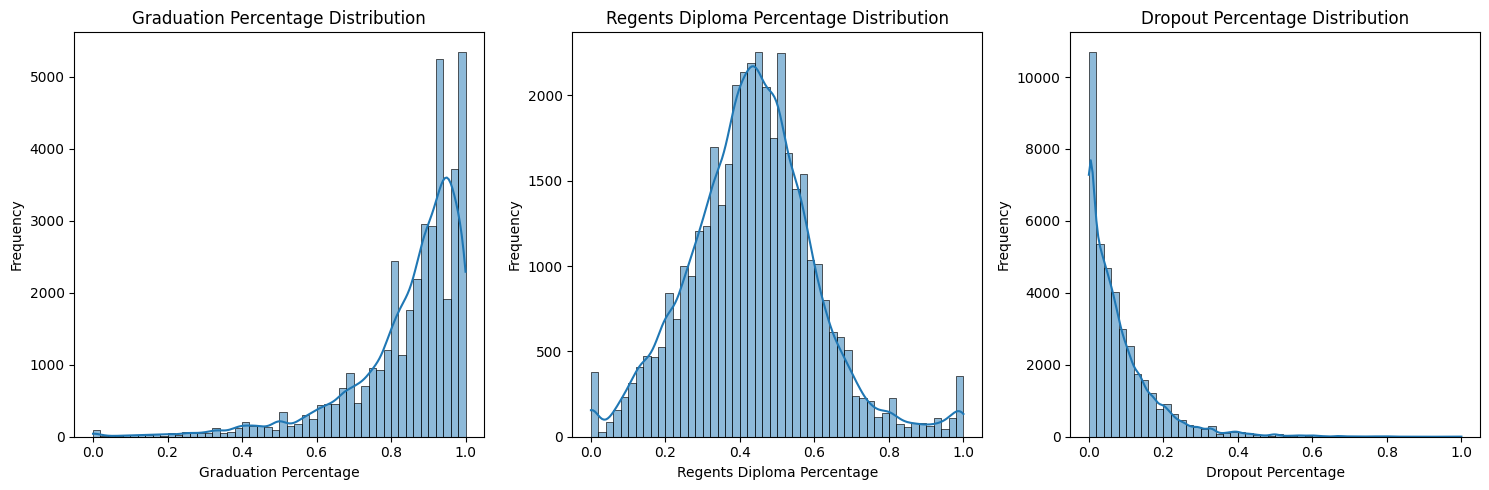

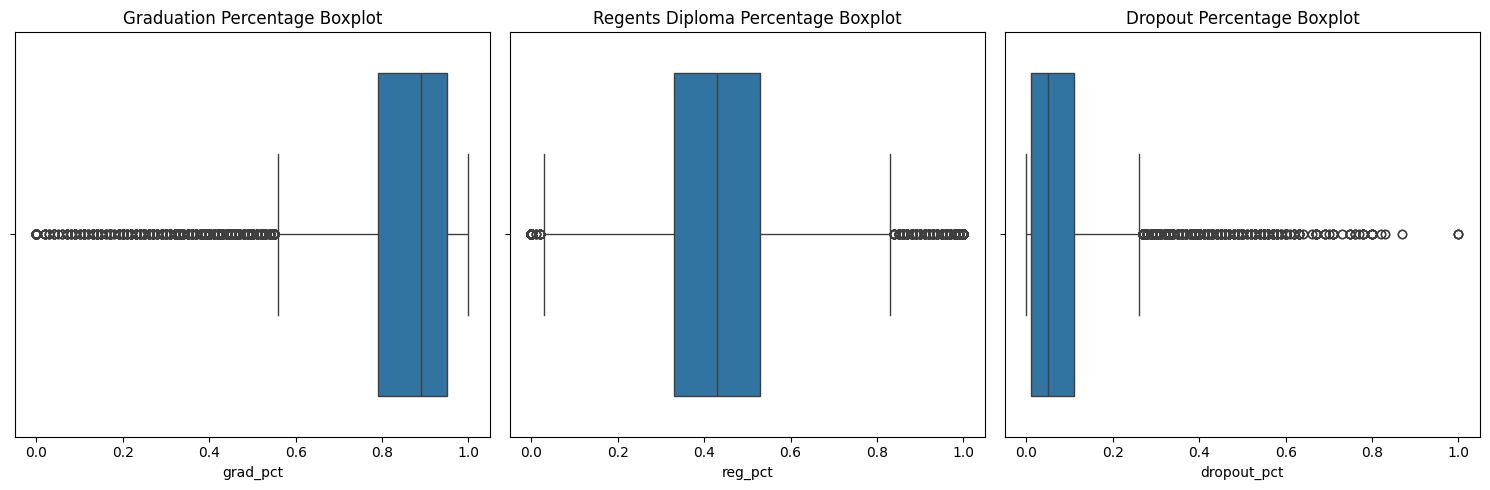

In [18]:
# Histograms for each percentage variable
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Customize the individual plots if needed, here is a basic setup
sns.histplot(df_copy['grad_pct'], bins=50, kde=True, ax=axes[0])
axes[0].set_title('Graduation Percentage Distribution')
axes[0].set_xlabel('Graduation Percentage')
axes[0].set_ylabel('Frequency')

sns.histplot(df_copy['reg_pct'], bins=50, kde=True, ax=axes[1])
axes[1].set_title('Regents Diploma Percentage Distribution')
axes[1].set_xlabel('Regents Diploma Percentage')
axes[1].set_ylabel('Frequency')

sns.histplot(df_copy['dropout_pct'], bins=50, kde=True, ax=axes[2])
axes[2].set_title('Dropout Percentage Distribution')
axes[2].set_xlabel('Dropout Percentage')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Box plots to show the range and outliers for the percentage variables
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.boxplot(x=df_copy['grad_pct'], ax=axes[0])
axes[0].set_title('Graduation Percentage Boxplot')

sns.boxplot(x=df_copy['reg_pct'], ax=axes[1])
axes[1].set_title('Regents Diploma Percentage Boxplot')

sns.boxplot(x=df_copy['dropout_pct'], ax=axes[2])
axes[2].set_title('Dropout Percentage Boxplot')

plt.tight_layout()
plt.show()

- **Graduation Percentage Distribution**: The histogram shows that the graduation percentage is heavily skewed towards higher percentages, indicating that a majority of the data points have high graduation rates, with the peak frequency at around 90%. The boxplot shows a relatively small interquartile range, but with some outliers on the lower end, which suggests that while most institutions have high graduation rates, there are a few with notably lower rates.

- **Regents Diploma Percentage Distribution**: This histogram has a more bell-shaped distribution, centered around 40-50%, but it’s still skewed to the right. It indicates a more varied spread in the Regents diploma percentages across the data points. The boxplot reflects a broader interquartile range compared to graduation percentages, along with outliers on both ends, suggesting that there's a wide variation in the percentage of students receiving a Regents diploma.

- **Dropout Percentage Distribution**: The dropout percentage histogram is highly skewed to the right with a peak close to 0%, showing that most institutions have very low dropout rates. The boxplot confirms this with a tight interquartile range and outliers that are only present on the higher end, highlighting that while most institutions maintain low dropout percentages, there are exceptions with higher rates.

In summary, the institutions in our dataset tend to have high graduation rates and low dropout rates, with a moderate spread in the awarding of Regents diplomas. While the overall trends are positive, the presence of outliers, particularly in the Regents diploma and dropout percentages, indicates that some institutions deviate from these trends, which may require further investigation.

#### Object variable 

In [19]:
# Filter out the columns with integer dtype
object_columns = df_copy.select_dtypes(include=['object']).columns

# Get the statistical summary for integer columns
df_copy[object_columns].describe()


,aggregation_index,aggregation_type,aggregation_name,nrc_code,nrc_desc,county_code,county_name,membership_desc,subgroup_code,subgroup_name
count,39674,39674,39674,39674,39674,39674,39674,39674,39674,39674
unique,1,1,677,6,6,62,62,6,24,24
top,3,District,SYRACUSE CITY SCHOOL DISTRICT,5,Average Needs,58,SUFFOLK,2015 Total Cohort - 4 Year Outcome,1,All Students
freq,39674,39674,116,18260,18260,3996,3996,6676,4046,4046


- **aggregation_index**: There's only one unique value (3) across all 39,674 entries, suggesting that this dataset is focused on a single aggregation method or category.

- **aggregation_type**: Similar to aggregation_index, all entries are of a single type, named "District," indicating that the data is possibly aggregated at the district level.

- **aggregation_name**: The most frequently occurring aggregation name is "SYRACUSE CITY SCHOOL DISTRICT," which appears 116 times. However, there are 677 unique aggregation names, suggesting a wide variety of school districts represented in the data.

- **nrc_code** and **nrc_desc**: There are six unique "needs/resource capacity" codes with the code '5', labeled as "Average Needs," being the most frequent, appearing in 18,260 entries. This implies that most schools in the dataset have an average needs/resource capacity.

- **county_code** and **county_name**: With 62 unique entries, the dataset encompasses a broad range of counties. The county code '58', corresponding to "SUFFOLK," occurs most frequently with 3,996 occurrences.

- **membership_desc**: This column has six unique descriptions, with "2015 Total Cohort - 4 Year Outcome" being the most common, present in 6,676 records. It indicates a focus on a cohort of students tracked over a four-year period.

- **subgroup_code** and **subgroup_name**: There are 24 unique subgroup codes and names, with the subgroup "All Students" appearing the most frequently (4,046 times). This indicates that the data often considers the entire student body rather than specific subgroups.

- **reg_awd**: There are three unique values for this variable, with one particular value appearing in 32,258 records. This suggests a certain type of award or recognition is prevalent across the dataset.

Overall, the dataset reflects a comprehensive collection of educational data across numerous districts, with a focus on average needs schools, encompassing all students, and considering multiple years of outcomes. The variety in some fields, such as aggregation names and county codes, contrasts with the uniformity in others, such as aggregation index and type, painting a picture of standardized data collection with diverse local educational entities.

We observe two things:
- **The `aggregation_index` and `aggregation_type` variables have no variance; all values in these features are identical, so we can remove them.**

- **The variables come in pairs, so it's not necessary to retain both elements of each pair. We can delete:**
    - `nrc_desc` while keeping `nrc_code` because it is a categorical ordinal variable.
    - `county_name` while retaining `county_code`.
    - `subgroup_name` while preserving `subgroup_code`.

In [20]:
# Create mapping tables for each pair
nrc_mapping = df_copy[['nrc_code', 'nrc_desc']].drop_duplicates().set_index('nrc_code')
county_mapping = df_copy[['county_code', 'county_name']].drop_duplicates().set_index('county_code')
subgroup_mapping = df_copy[['subgroup_code', 'subgroup_name']].drop_duplicates().set_index('subgroup_code')

# Display the mapping table example
print("NRC Code to Description Mapping:")
nrc_mapping

NRC Code to Description Mapping:


,nrc_desc
nrc_code,
3,Urban-Suburban High Needs
5,Average Needs
6,Low Needs
4,Rural High Needs
2,Buffalo Rochester Yonkers Syracuse
1,NYC


In [21]:
# Display the mapping table example
print("\nCounty Code to Name Mapping:")
county_mapping


County Code to Name Mapping:


,county_name
county_code,
1,ALBANY
2,ALLEGANY
3,BROOME
4,CATTARAUGUS
5,CAYUGA
...,...
64,WASHINGTON
65,WAYNE
66,WESTCHESTER


In [22]:
# Display the mapping table example
print("\nSubgroup Code to Name Mapping:")
subgroup_mapping


Subgroup Code to Name Mapping:


,subgroup_name
subgroup_code,
1,All Students
2,Female
3,Male
5,Black
6,Hispanic
7,Asian/Pacific Islander
8,White
10,General Education Students
11,Students with Disabilities


We convert each DataFrame to a dictionary, so if we want these mappings form for easy lookup: 

In [23]:
nrc_dict = nrc_mapping['nrc_desc'].to_dict()
county_dict = county_mapping['county_name'].to_dict()
subgroup_dict = subgroup_mapping['subgroup_name'].to_dict()

# Example of using the dictionary to lookup a description
nrc_description_for_code_3 = nrc_dict[3]
print("Description for NRC code 3:", nrc_description_for_code_3)


Description for NRC code 3: Urban-Suburban High Needs


##### Dropping the features : 

Now we can drop the unnecessary and redundant variables

In [24]:
# Drop columns with no variance
df_copy.drop(columns=['aggregation_index', 'aggregation_type'], inplace=True)

# Drop the descriptive counterparts of code columns, retaining the codes
df_copy.drop(columns=['nrc_desc', 'county_name', 'subgroup_name'], inplace=True)

In [25]:
# Filter out the columns with object dtype
object_columns = df_copy.select_dtypes(include=['object']).columns

# Get the statistical summary for object columns
df_copy[object_columns].describe()


,aggregation_name,nrc_code,county_code,membership_desc,subgroup_code
count,39674,39674,39674,39674,39674
unique,677,6,62,6,24
top,SYRACUSE CITY SCHOOL DISTRICT,5,58,2015 Total Cohort - 4 Year Outcome,1
freq,116,18260,3996,6676,4046


First, we are goinf to check the features who have the most unique values which are aggregation_name, county_code and subgroup_code. I want to see how is the distribution of those cat.

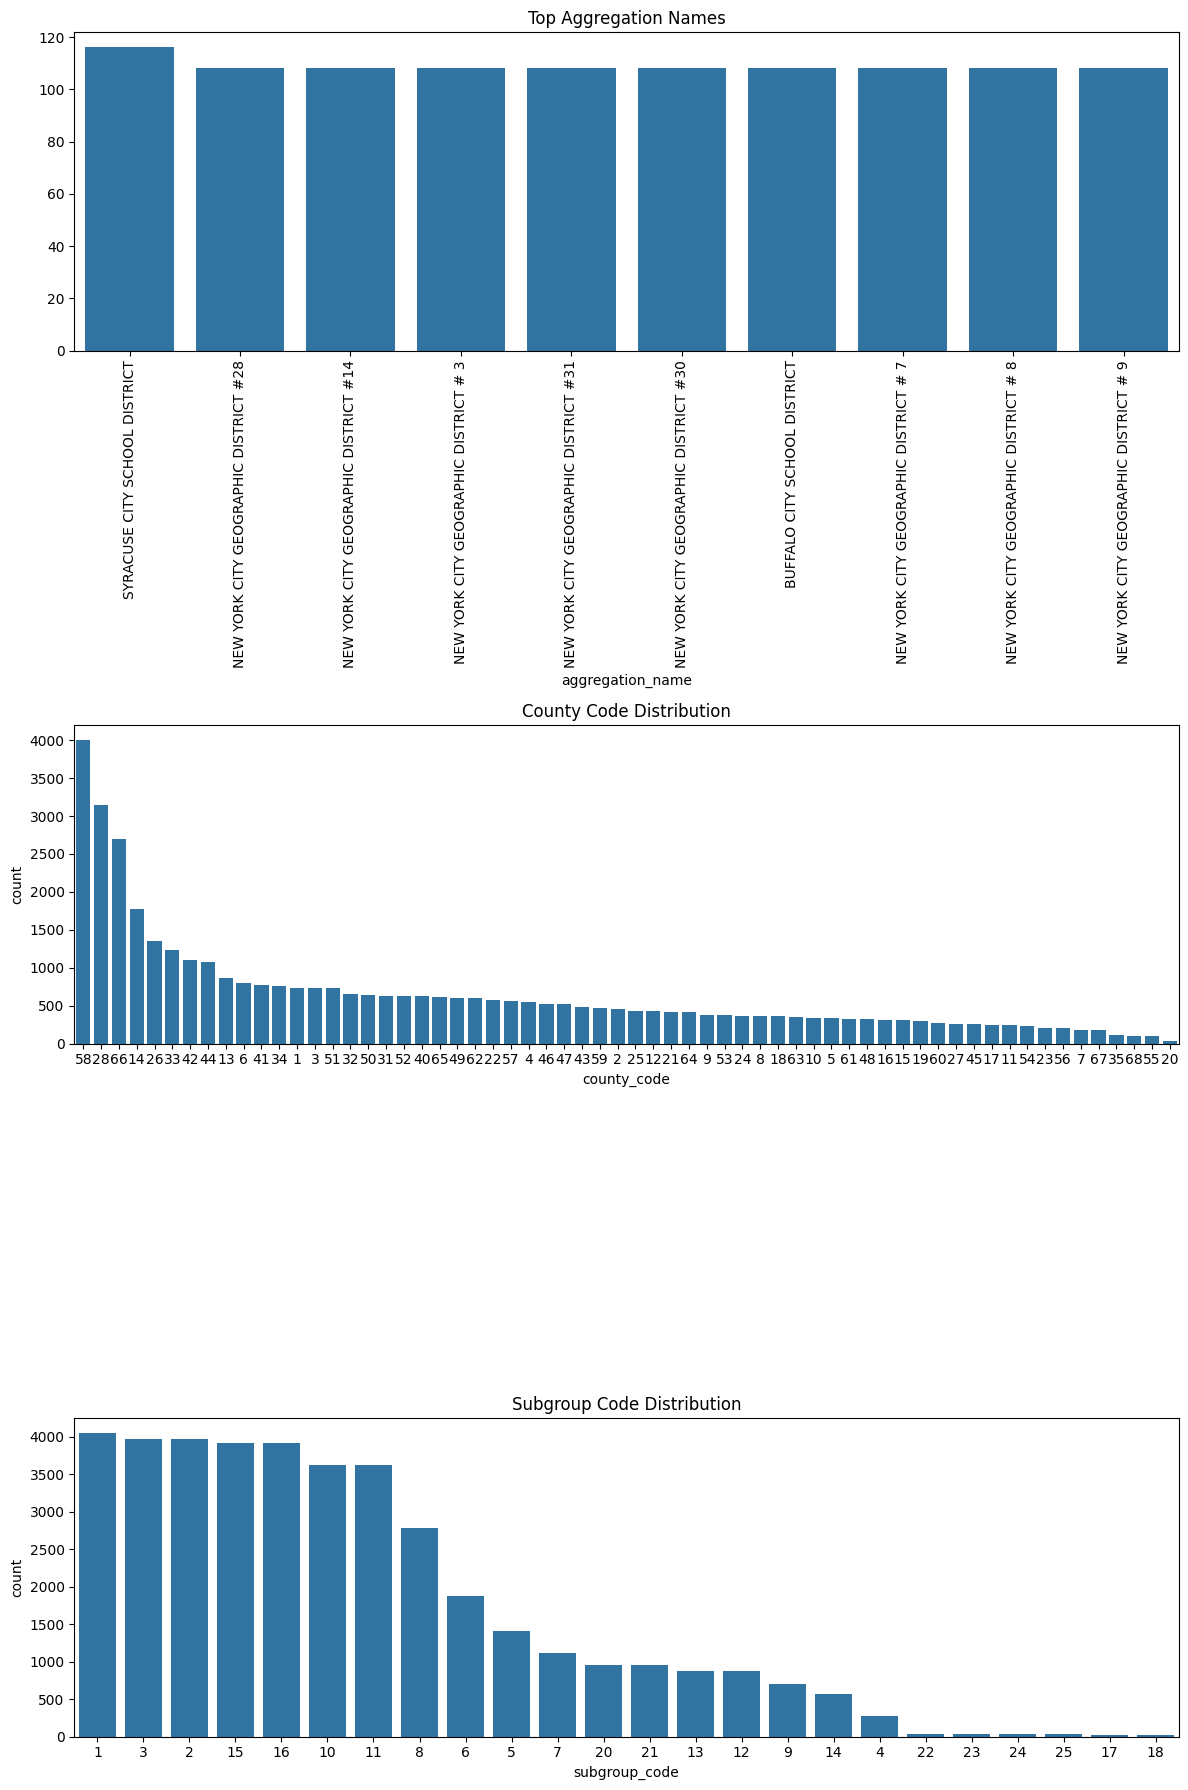

In [26]:
# Define the number of top categories
TOP_CATEGORIES = 10

# Set up the matplotlib figure
fig, axes = plt.subplots(3, 1, figsize=(12, 18))

# Aggregation Name
top_aggregation_names = df_copy['aggregation_name'].value_counts().nlargest(TOP_CATEGORIES)
sns.barplot(ax=axes[0], x=top_aggregation_names.index, y=top_aggregation_names.values)
axes[0].set_title('Top Aggregation Names')
axes[0].tick_params(axis='x', rotation=90)

# County Code
# Make sure to use the correct column name as it appears in df_copy
sns.countplot(ax=axes[1], x='county_code', data=df_copy, order=df_copy['county_code'].value_counts().index)
axes[1].set_title('County Code Distribution')

# Subgroup Code
# Again, use the correct column name here. It should be all lowercase if that's how it is in your DataFrame
sns.countplot(ax=axes[2], x='subgroup_code', data=df_copy, order=df_copy['subgroup_code'].value_counts().index)
axes[2].set_title('Subgroup Code Distribution')

plt.tight_layout()
plt.show()


We observe, for the aggregation names, that the top 10 most common unique values nearly all have the same frequencies, ranging between 120 and 100 appearances in the dataset. We will later examine the values that appear least frequently.

For the distribution of county codes, we note 8 values that appear more than 1000 times: 58, 28, 66, 14, 26, 33, 42, and 44. The majority are observed between 1000 and 500 times, while a few are noted to appear less than 500 times. We plan to group the values that appear less than 100 times in the dataset to reduce the number of unique values in this feature.

Finally, regarding the subgroup code feature, we note that 8 features appear more than 2500 times. A few are observed between 2500 and 500 times, and 7 appear less than 500 times. We intend to group those with fewer than 500 appearances to streamline the dataset.

County code : 

In [27]:
# First, let's find the county codes that appear less than 100 times.
county_code_counts = df_copy['county_code'].value_counts()
county_codes_to_group = county_code_counts[county_code_counts < 100].index

# Now, let's create a new column where we group these values.
# We will call the new grouped value 'Other'.
df_copy['county_code'] = df_copy['county_code'].apply(lambda x: 'Other' if x in county_codes_to_group else x)

# Check the changes by looking at the new value counts
grouped_counts = df_copy['county_code'].value_counts()

# Display the first few rows to verify
print(grouped_counts.head())

county_code
58    3996
28    3152
66    2700
14    1770
26    1356
Name: count, dtype: int64


Subgroup code:

In [28]:
# Find the subgroup codes that appear less than 500 times
subgroup_code_counts = df_copy['subgroup_code'].value_counts()
subgroup_codes_to_group = subgroup_code_counts[subgroup_code_counts < 500].index

# Create a new column where we group these values
# The new grouped values will be named 'Other'
df_copy['subgroup_code'] = df_copy['subgroup_code'].replace(subgroup_codes_to_group, 'Other')

# Check the changes by looking at the new value counts
grouped_subgroup_counts = df_copy['subgroup_code'].value_counts()

# Display the first few rows to verify
print(grouped_subgroup_counts.head())

subgroup_code
1     4046
3     3970
2     3970
15    3918
16    3918
Name: count, dtype: int64


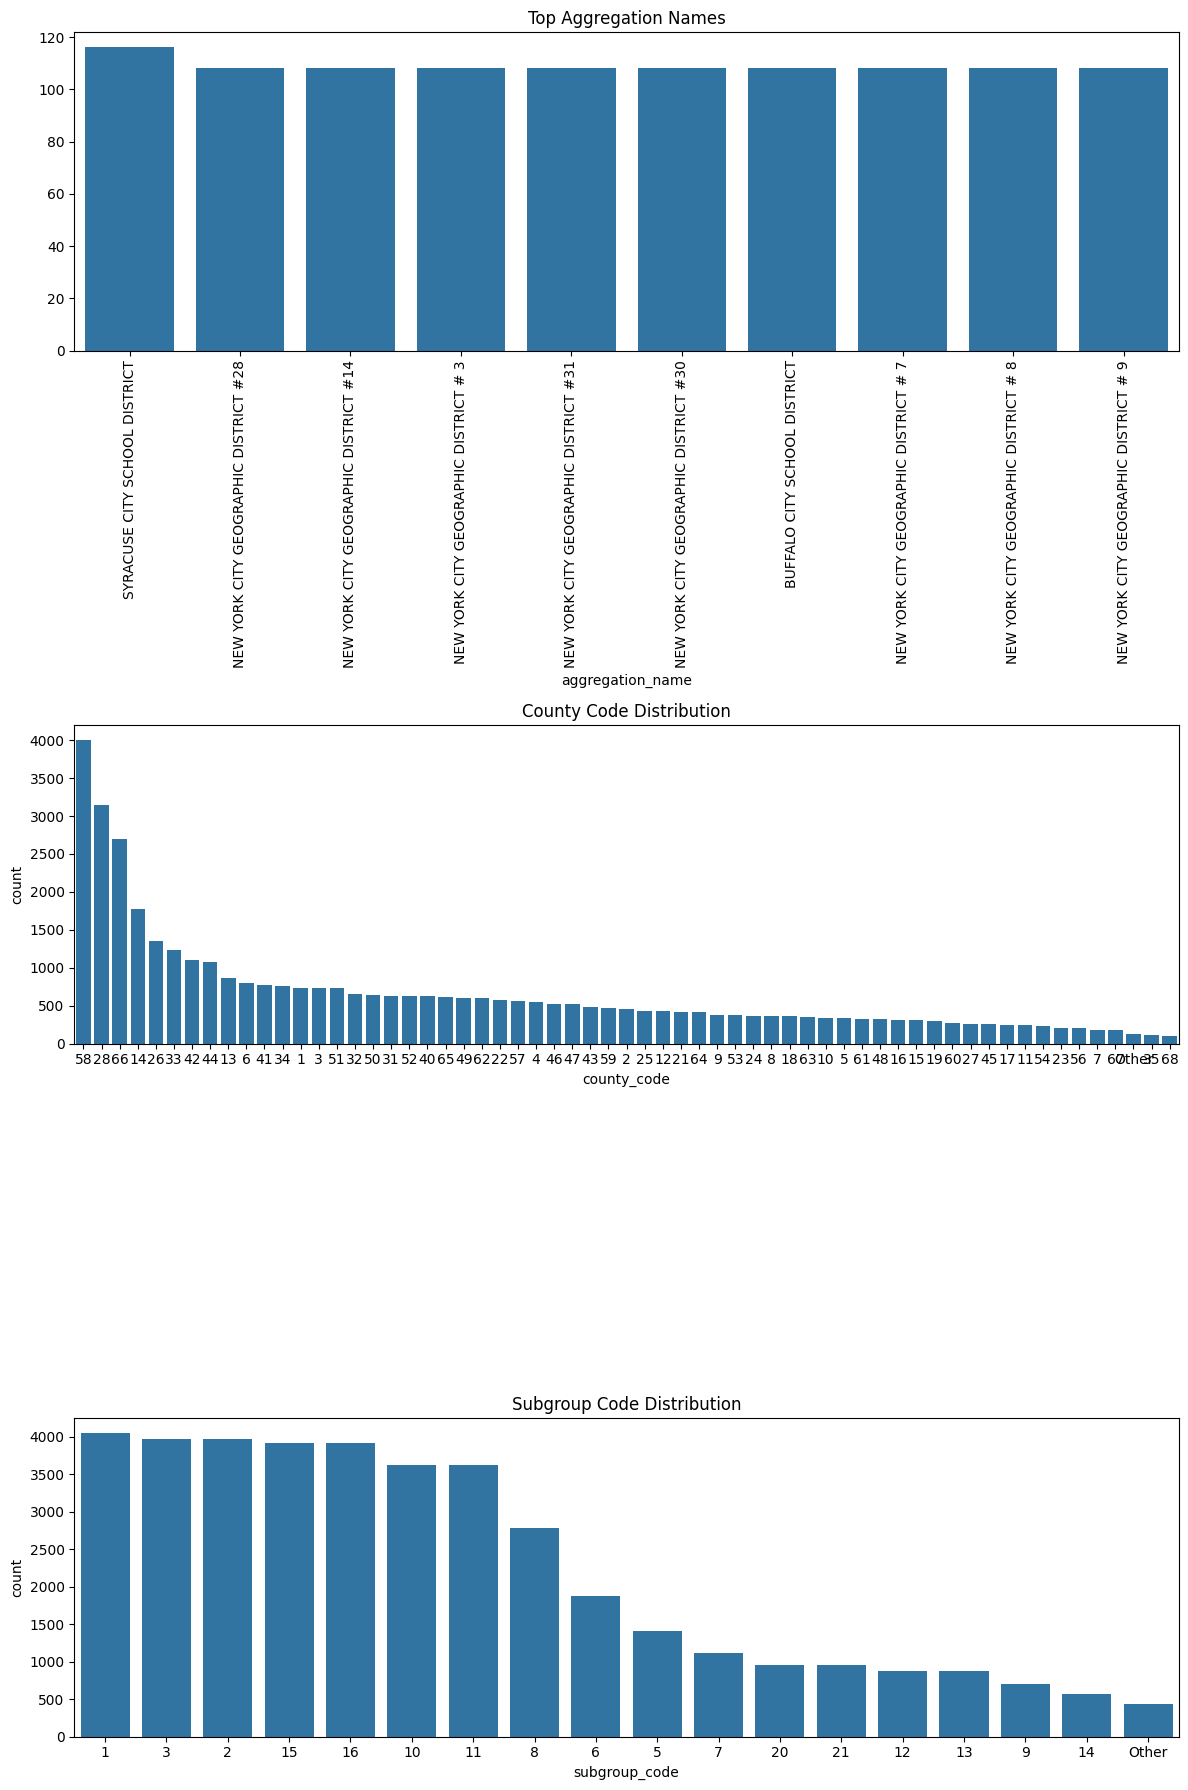

In [29]:
# Define the number of top categories you want to display
TOP_CATEGORIES = 10

# Set up the matplotlib figure
fig, axes = plt.subplots(3, 1, figsize=(12, 18))

# Aggregation Name
top_aggregation_names = df_copy['aggregation_name'].value_counts().nlargest(TOP_CATEGORIES)
sns.barplot(ax=axes[0], x=top_aggregation_names.index, y=top_aggregation_names.values)
axes[0].set_title('Top Aggregation Names')
axes[0].tick_params(axis='x', rotation=90)

# County Code
# Make sure to use the correct column name as it appears in df_copy
sns.countplot(ax=axes[1], x='county_code', data=df_copy, order=df_copy['county_code'].value_counts().index)
axes[1].set_title('County Code Distribution')

# Subgroup Code
# Again, use the correct column name here. It should be all lowercase if that's how it is in your DataFrame
sns.countplot(ax=axes[2], x='subgroup_code', data=df_copy, order=df_copy['subgroup_code'].value_counts().index)
axes[2].set_title('Subgroup Code Distribution')

plt.tight_layout()
plt.show()


We now have fewer distinct values for these two variables, which will make it easier for the model.

Now, we want to check the top 50 least frequent values for the 'aggregation_name' column.

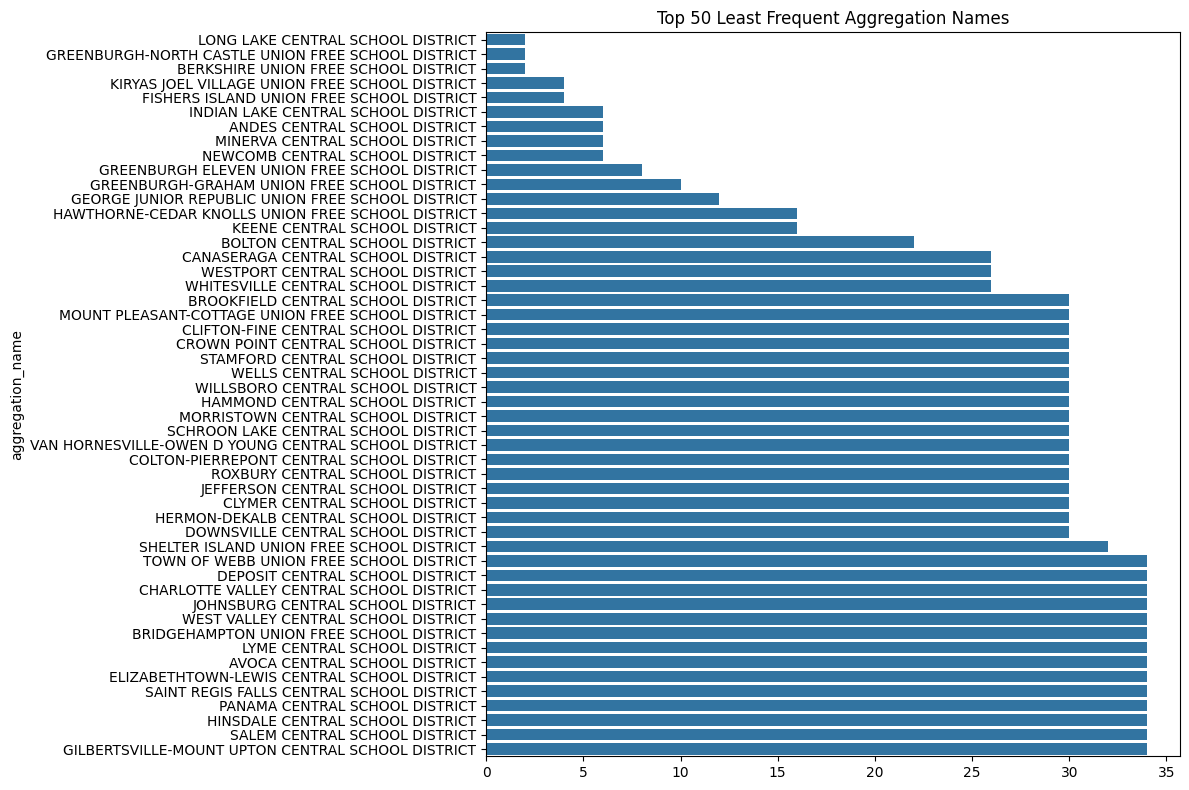

In [30]:
# Define the number of least frequent categories you want to display
LEAST_FREQUENT_CATEGORIES = 50

# Set up the matplotlib figure for one plot
fig, ax = plt.subplots(figsize=(12, 8))

# Find the top 50 least frequent values in 'aggregation_name'
least_frequent_aggregation_names = df_copy['aggregation_name'].value_counts().nsmallest(LEAST_FREQUENT_CATEGORIES)
sns.barplot(ax=ax, x=least_frequent_aggregation_names.values, y=least_frequent_aggregation_names.index)
ax.set_title('Top 50 Least Frequent Aggregation Names')
ax.tick_params(axis='y', rotation=0)

plt.tight_layout()
plt.show()

We are going to group the aggregation names that have fewer than 20 appearances in the dataset, for the same reasons.

In [31]:
# Find aggregation names that appear fewer than 20 times
aggregation_name_counts = df_copy['aggregation_name'].value_counts()
aggregation_names_to_group = aggregation_name_counts[aggregation_name_counts < 20].index

# Group these aggregation names by replacing them with 'Other'
df_copy['aggregation_name'] = df_copy['aggregation_name'].apply(
    lambda x: 'Other' if x in aggregation_names_to_group else x
)

# Verify the changes
print(df_copy['aggregation_name'].value_counts().tail(20))


aggregation_name
BROOKFIELD CENTRAL SCHOOL DISTRICT                      30
HAMMOND CENTRAL SCHOOL DISTRICT                         30
COLTON-PIERREPONT CENTRAL SCHOOL DISTRICT               30
WILLSBORO CENTRAL SCHOOL DISTRICT                       30
DOWNSVILLE CENTRAL SCHOOL DISTRICT                      30
HERMON-DEKALB CENTRAL SCHOOL DISTRICT                   30
SCHROON LAKE CENTRAL SCHOOL DISTRICT                    30
CROWN POINT CENTRAL SCHOOL DISTRICT                     30
ROXBURY CENTRAL SCHOOL DISTRICT                         30
STAMFORD CENTRAL SCHOOL DISTRICT                        30
VAN HORNESVILLE-OWEN D YOUNG CENTRAL SCHOOL DISTRICT    30
JEFFERSON CENTRAL SCHOOL DISTRICT                       30
CLYMER CENTRAL SCHOOL DISTRICT                          30
WELLS CENTRAL SCHOOL DISTRICT                           30
MOUNT PLEASANT-COTTAGE UNION FREE SCHOOL DISTRICT       30
CLIFTON-FINE CENTRAL SCHOOL DISTRICT                    30
CANASERAGA CENTRAL SCHOOL DISTRICT     

In [32]:
other_values_count = (df_copy['aggregation_name'] == 'Other').sum()
print(f"Number of 'Other' values: {other_values_count}")


Number of 'Other' values: 100


This will be easier like that. 

No we check the 2 others varaibles : nrc_code and membership_desc.

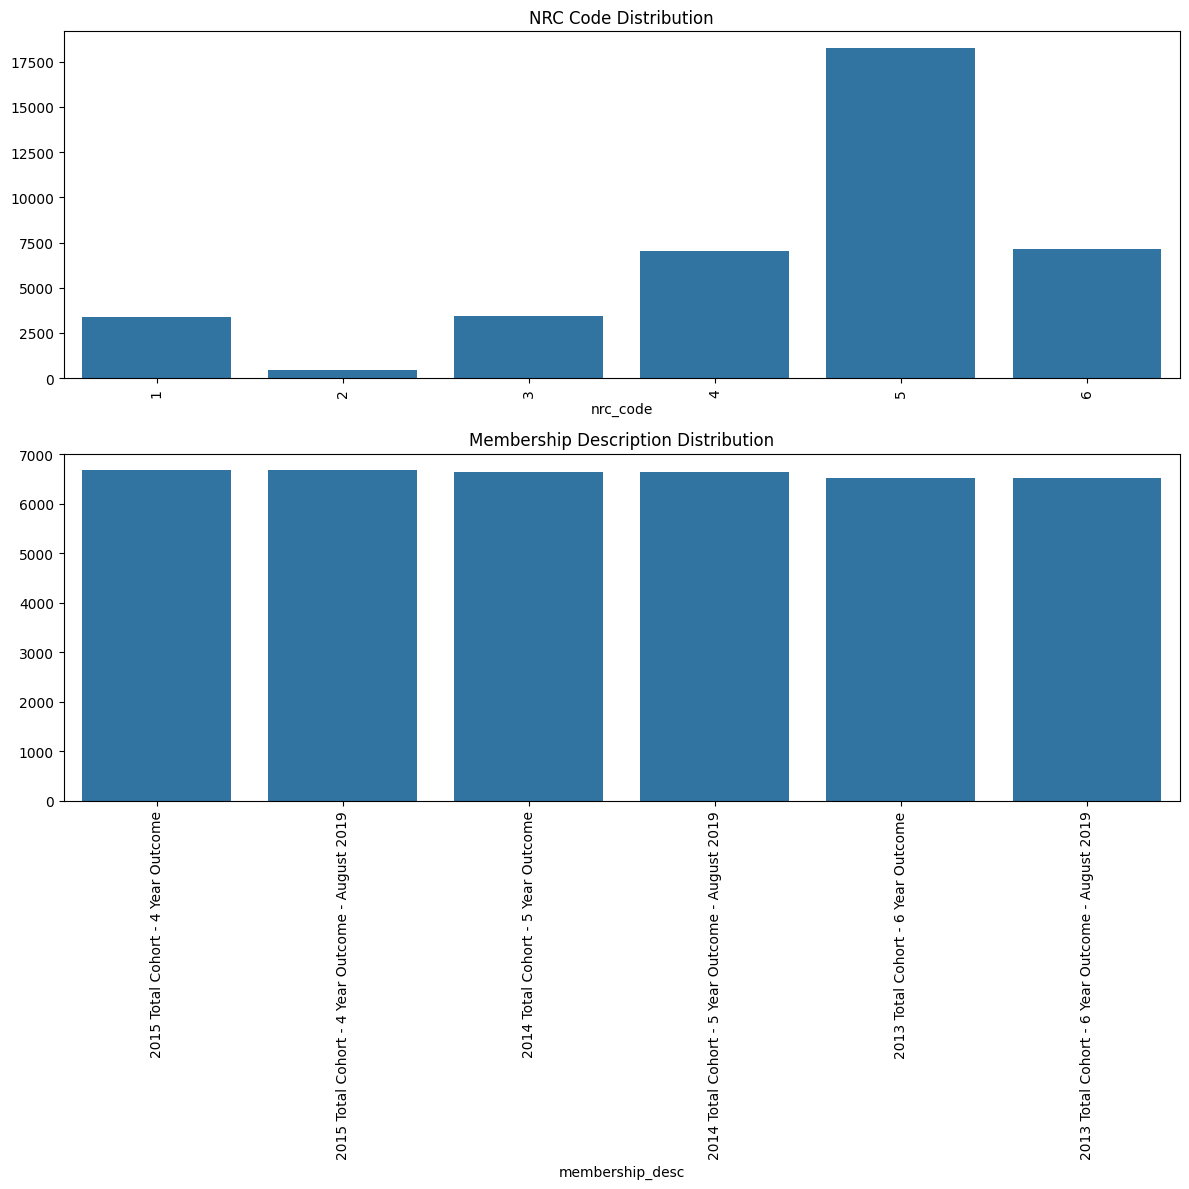

In [33]:
# Set up the matplotlib figure for two additional subplots
fig, axes = plt.subplots(2, 1, figsize=(12, 12))

# NRC Code
# Use the correct column name as it appears in df_copy
top_nrc_codes = df_copy['nrc_code'].value_counts()
sns.barplot(ax=axes[0], x=top_nrc_codes.index, y=top_nrc_codes.values)
axes[0].set_title('NRC Code Distribution')
axes[0].tick_params(axis='x', rotation=90)

# Membership Description
top_membership_desc = df_copy['membership_desc'].value_counts()
sns.barplot(ax=axes[1], x=top_membership_desc.index, y=top_membership_desc.values)
axes[1].set_title('Membership Description Distribution')
axes[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()


The membership distribution is very balanced; there's no need for any changes.

Regarding the NRC code, the situation is different. The value '5' is significantly more prevalent than the others, with a count of around 17,500, compared to 7,500 appearances for both '4' and '6', and even more for the rest. We will merge the values '1', '2', and '3' to achieve a more balanced distribution.

In [34]:
# Define the NRC codes to be merged: 1, 2, and 3
nrc_codes_to_merge = [1, 2, 3]

# Create a new column that combines the NRC codes 1, 2, and 3 into a single category '1, 2 or 3'
df_copy['nrc_code'] = df_copy['nrc_code'].apply(lambda x: '1, 2 or 3' if x in nrc_codes_to_merge else x)

# Now let's check the new value counts in the combined column
nrc_code_combined_counts = df_copy['nrc_code'].value_counts()

# Display the modified distribution
print(nrc_code_combined_counts)


nrc_code
5            18260
1, 2 or 3     7230
6             7136
4             7048
Name: count, dtype: int64


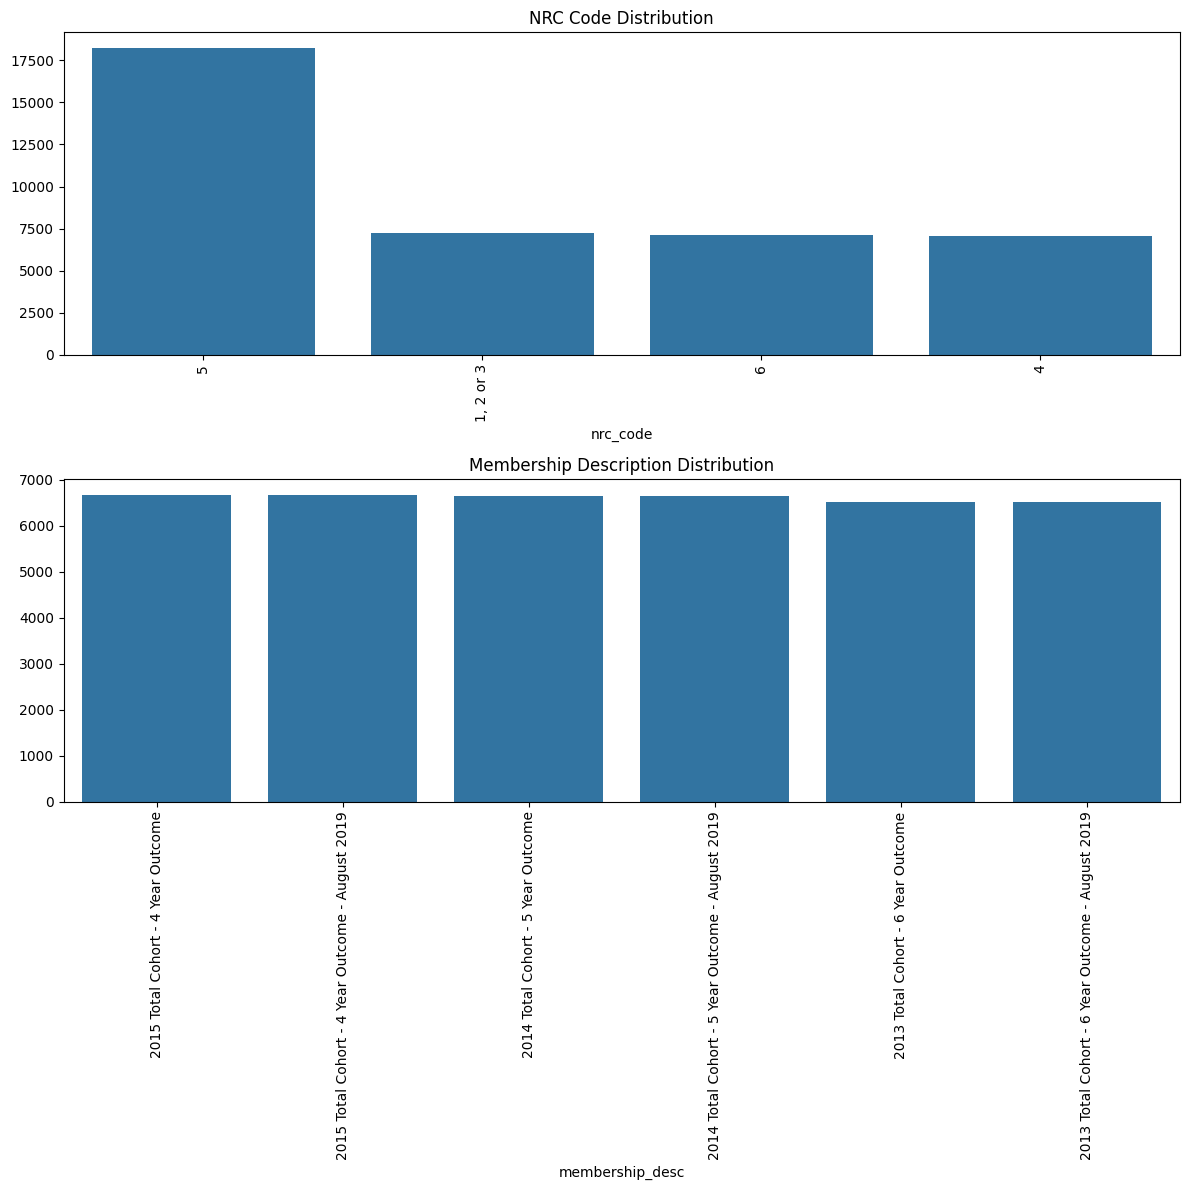

In [35]:
# Set up the matplotlib figure for two additional subplots
fig, axes = plt.subplots(2, 1, figsize=(12, 12))

# NRC Code
# Use the correct column name as it appears in df_copy
top_nrc_codes = df_copy['nrc_code'].value_counts()
sns.barplot(ax=axes[0], x=top_nrc_codes.index, y=top_nrc_codes.values)
axes[0].set_title('NRC Code Distribution')
axes[0].tick_params(axis='x', rotation=90)

# Membership Description
top_membership_desc = df_copy['membership_desc'].value_counts()
sns.barplot(ax=axes[1], x=top_membership_desc.index, y=top_membership_desc.values)
axes[1].set_title('Membership Description Distribution')
axes[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()


Now it way more distributed and easier for the model. 

#### Boolean variable

In [36]:
# Filter out the columns with integer dtype
bool_columns = df_copy.select_dtypes(include=['boolean']).columns

# Get the statistical summary for integer columns
df_copy[bool_columns].describe()

,nyc_ind
count,39674
unique,2
top,False
freq,36292


Value counts for the boolean column 'nyc_ind':
nyc_ind
False    36292
True      3382
Name: count, dtype: int64


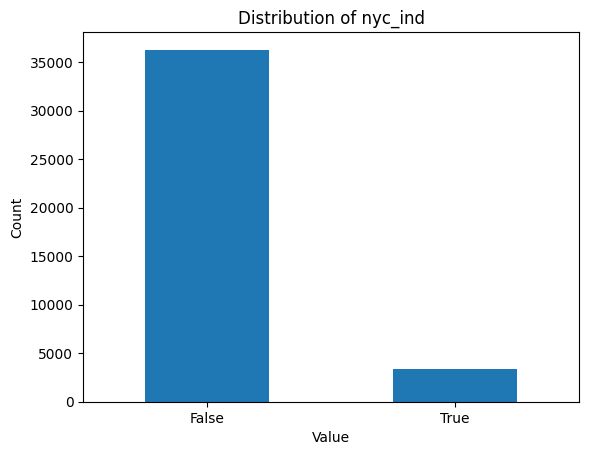

In [37]:
# Assuming df_copy is your DataFrame and it's already loaded with your data# Select the boolean column, here we assume there's only one boolean column in df_copy
bool_column = df_copy.select_dtypes(include=['bool']).columns[0]

# Calculate the counts for each value (True and False) in the boolean column
bool_value_counts = df_copy[bool_column].value_counts()

# Print the counts of True and False
print(f"Value counts for the boolean column '{bool_column}':")
print(bool_value_counts)

# If you want to plot the counts
bool_value_counts.plot(kind='bar', title=f"Distribution of {bool_column}")
plt.xlabel('Value')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=[str(bool_value_counts.index[0]), str(bool_value_counts.index[1])], rotation=0)
plt.show()


**Correlation Analysis**

In [38]:
#Breaking down features by counts and by rates
predictors = [ i for i in list(df.columns) if 'pct' or 'cnt' in i]
counts = [i for i in predictors if 'cnt' in i]
rates = [i for i in predictors if 'pct' in i]
cnt_corr = df[counts].corr()
pct_corr = df[rates].corr()

<Axes: >

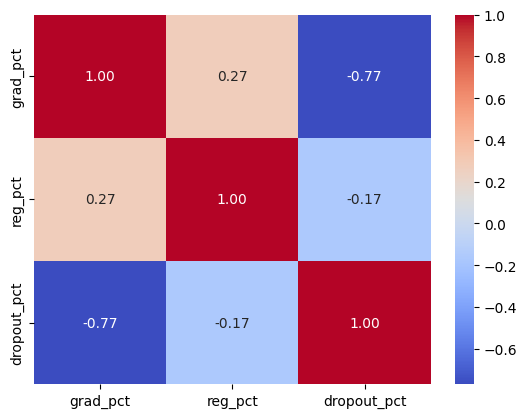

In [39]:
sns.heatmap(pct_corr,annot=True, cmap='coolwarm', fmt=".2f" )

Understandably there is a high negative correlation between dropout percentage and graduation rate. Since the absolute value of the correlation is not greated than 80% then both will be kept.

<Axes: >

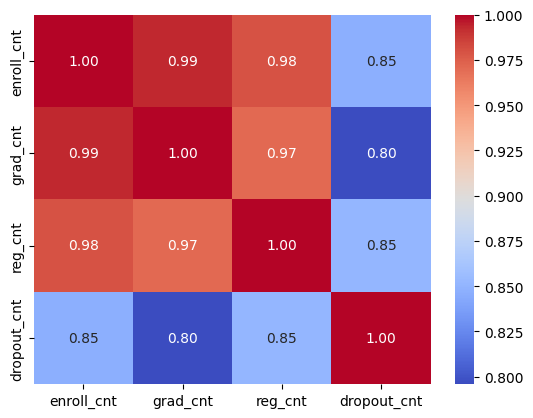

In [40]:
sns.heatmap(cnt_corr, annot = True, cmap = 'coolwarm', fmt=".2f" )

All of the counts data have high correlations with each other in both directions. Correlation threshold will be adjusted to |0.9| since thecoefficients are higher. Graduation count and enrollment count will be dropped from the feature set. Regents variables will be dropped because the target is derrived from these variables. 

Data Preparation

In [41]:
def preprocessor(df, target):
  """
  Preparing data for model training, this will include dropping variables that are unecessary, balancing the target, and creating dummy variables

  Args:
    df: dataset to be analyzed
    target(str): column name of target variable


  Returns:
    A DataFrame with:
     -target values transformed
     -numerical values standardized
     -balanced target variable distribution
     
"""

  categorical_variables = list(df.select_dtypes(include = object))
  categorical_variables = list(set(categorical_variables) - set(target))
  numerical_variables = list(df.select_dtypes(exclude = object))
  numerical_variables = list(set(numerical_variables) - set(target))

  #gathering variables with zero variance
  no_var = []
  for i in numerical_variables:
      if df[i].std() == 0.0:
          no_var.append(i)

  numerical_variables = list(set(numerical_variables) - set(no_var))

  #categorical variables with too much variance 
  high_card = []
  for i in categorical_variables:
    if len(df[i].value_counts().index) > 200:
       high_card.append(i)

  #categorical variables with zero variance 
  low_card = []
  for i in categorical_variables:
     if len(df[i].value_counts().index) == 1:
        low_card.append(i)



#dropping features with zero variance and high cardinality 
  df.drop(no_var, axis = 1, inplace = True)
  df.drop(high_card, axis = 1, inplace = True)
  df.drop(low_card, axis = 1, inplace = True)
  
  drops = ['reg_cnt', 'reg_pct', 'grad_cnt', 'enroll_cnt']
  df.drop(drops, axis = 1, inplace = True)
  
  categorical_variables = list(df.select_dtypes(include = object))
  categorical_variables = list(set(categorical_variables) - set(target))
  
#creating dummy variables
  dummy_variables = pd.get_dummies(df[categorical_variables], drop_first = True)
  df.drop(categorical_variables, axis = 1, inplace = True)
  df = pd.concat([dummy_variables, df], axis =1)

#balancing target variable with oversampling
  def oversampler(df, target):
    oversamp = SMOTE(random_state = 42)
    input_var = [i for i in list(df.columns) if i != target]
    X, y = oversamp.fit_resample(df[input_var], df[target])
    X = pd.DataFrame(X, columns = input_var)
    y = pd.DataFrame(y, columns = [i for i in df.columns if i == target])
    df = pd.concat([X, y], axis = 1)
    df.dropna(inplace = True)
    return df

  df = oversampler(df, target)

  return df

In [42]:
df_copy = preprocessor(df.copy(), 'reg_awd')
df_copy

,county_name_ALLEGANY,county_name_BRONX,county_name_BROOME,county_name_CATTARAUGUS,county_name_CAYUGA,county_name_CHAUTAUQUA,county_name_CHEMUNG,county_name_CHENANGO,county_name_CLINTON,county_name_COLUMBIA,...,subgroup_name_Students with Disabilities,subgroup_name_White,nrc_code,county_code,nyc_ind,subgroup_code,grad_pct,dropout_cnt,dropout_pct,reg_awd
0,False,False,False,False,False,False,False,False,False,False,...,False,False,3,1,0,1,0.710000,148,0.220000,1
1,False,False,False,False,False,False,False,False,False,False,...,False,False,3,1,0,2,0.760000,65,0.200000,1
2,False,False,False,False,False,False,False,False,False,False,...,False,False,3,1,0,3,0.650000,83,0.250000,1
3,False,False,False,False,False,False,False,False,False,False,...,False,False,3,1,0,5,0.680000,91,0.250000,1
4,False,False,False,False,False,False,False,False,False,False,...,False,False,3,1,0,6,0.590000,28,0.290000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96769,True,False,False,False,False,False,False,False,False,False,...,False,False,4,2,0,3,0.899029,1,0.106214,2
96770,False,False,False,False,False,False,False,False,False,False,...,False,False,1,34,1,9,0.932110,1,0.048012,2
96771,False,False,False,False,False,False,False,False,False,False,...,False,False,2,66,0,2,0.920000,30,0.033068,2
96772,False,False,False,True,False,False,False,False,False,False,...,False,False,5,4,0,2,1.000000,0,0.000000,2


In [43]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96774 entries, 0 to 96773
Columns: 102 entries, county_name_ALLEGANY to reg_awd
dtypes: bool(94), float64(2), int64(6)
memory usage: 14.6 MB


Target Variable 

In [44]:
df = preprocessor(df, 'reg_awd')
df['reg_awd'].value_counts()

reg_awd
1    32258
0    32258
2    32258
Name: count, dtype: int64

**Model Building**

Decision Tree, we are going to be trying Decison Tree modeling using Entropy and Gini to compare the results and see which performes better in this scenario. 

Fitting Decision Tree: Measures Purification using Gini Index

In [45]:
#splitting into training and testing 

X = df.drop('reg_awd', axis = 1)
y = df['reg_awd']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 0)

#creating object of first decision tree classifier using gini purity measure.

tree1 = tree.DecisionTreeClassifier(min_samples_leaf = 3, max_depth = 3)

tree1.fit(X_train, y_train)

y_pred = tree1.predict(X_test)

print('confusion matrix of tree1:', '\n', confusion_matrix(y_test, y_pred))
print('\n')
print(classification_report(y_test, y_pred))

confusion matrix of tree1: 
 [[7426 2122  287]
 [1640 7742  286]
 [ 520 5693 3317]]


              precision    recall  f1-score   support

           0       0.77      0.76      0.76      9835
           1       0.50      0.80      0.61      9668
           2       0.85      0.35      0.49      9530

    accuracy                           0.64     29033
   macro avg       0.71      0.63      0.62     29033
weighted avg       0.71      0.64      0.63     29033



Classification Report:

    Precision:
        Class 0: 77%
        Class 1: 50%
        Class 2: 85%
    Recall:
        Class 0: 76%
        Class 1: 80%
        Class 2: 35%
    F1-Score:
        Class 0: 76%
        Class 1: 61%
        Class 2: 49%

Summary Metrics:

    Accuracy: 64%
    Macro Avg: Precision, recall, and F1-score averaged across all classes, giving each class equal weight.
    Weighted Avg: Precision, recall, and F1-score averaged across all classes, considering the number of true instances for each class.

This model also shows lower performance compared to the first one, particularly in terms of precision and recall for classes 1 and 2.

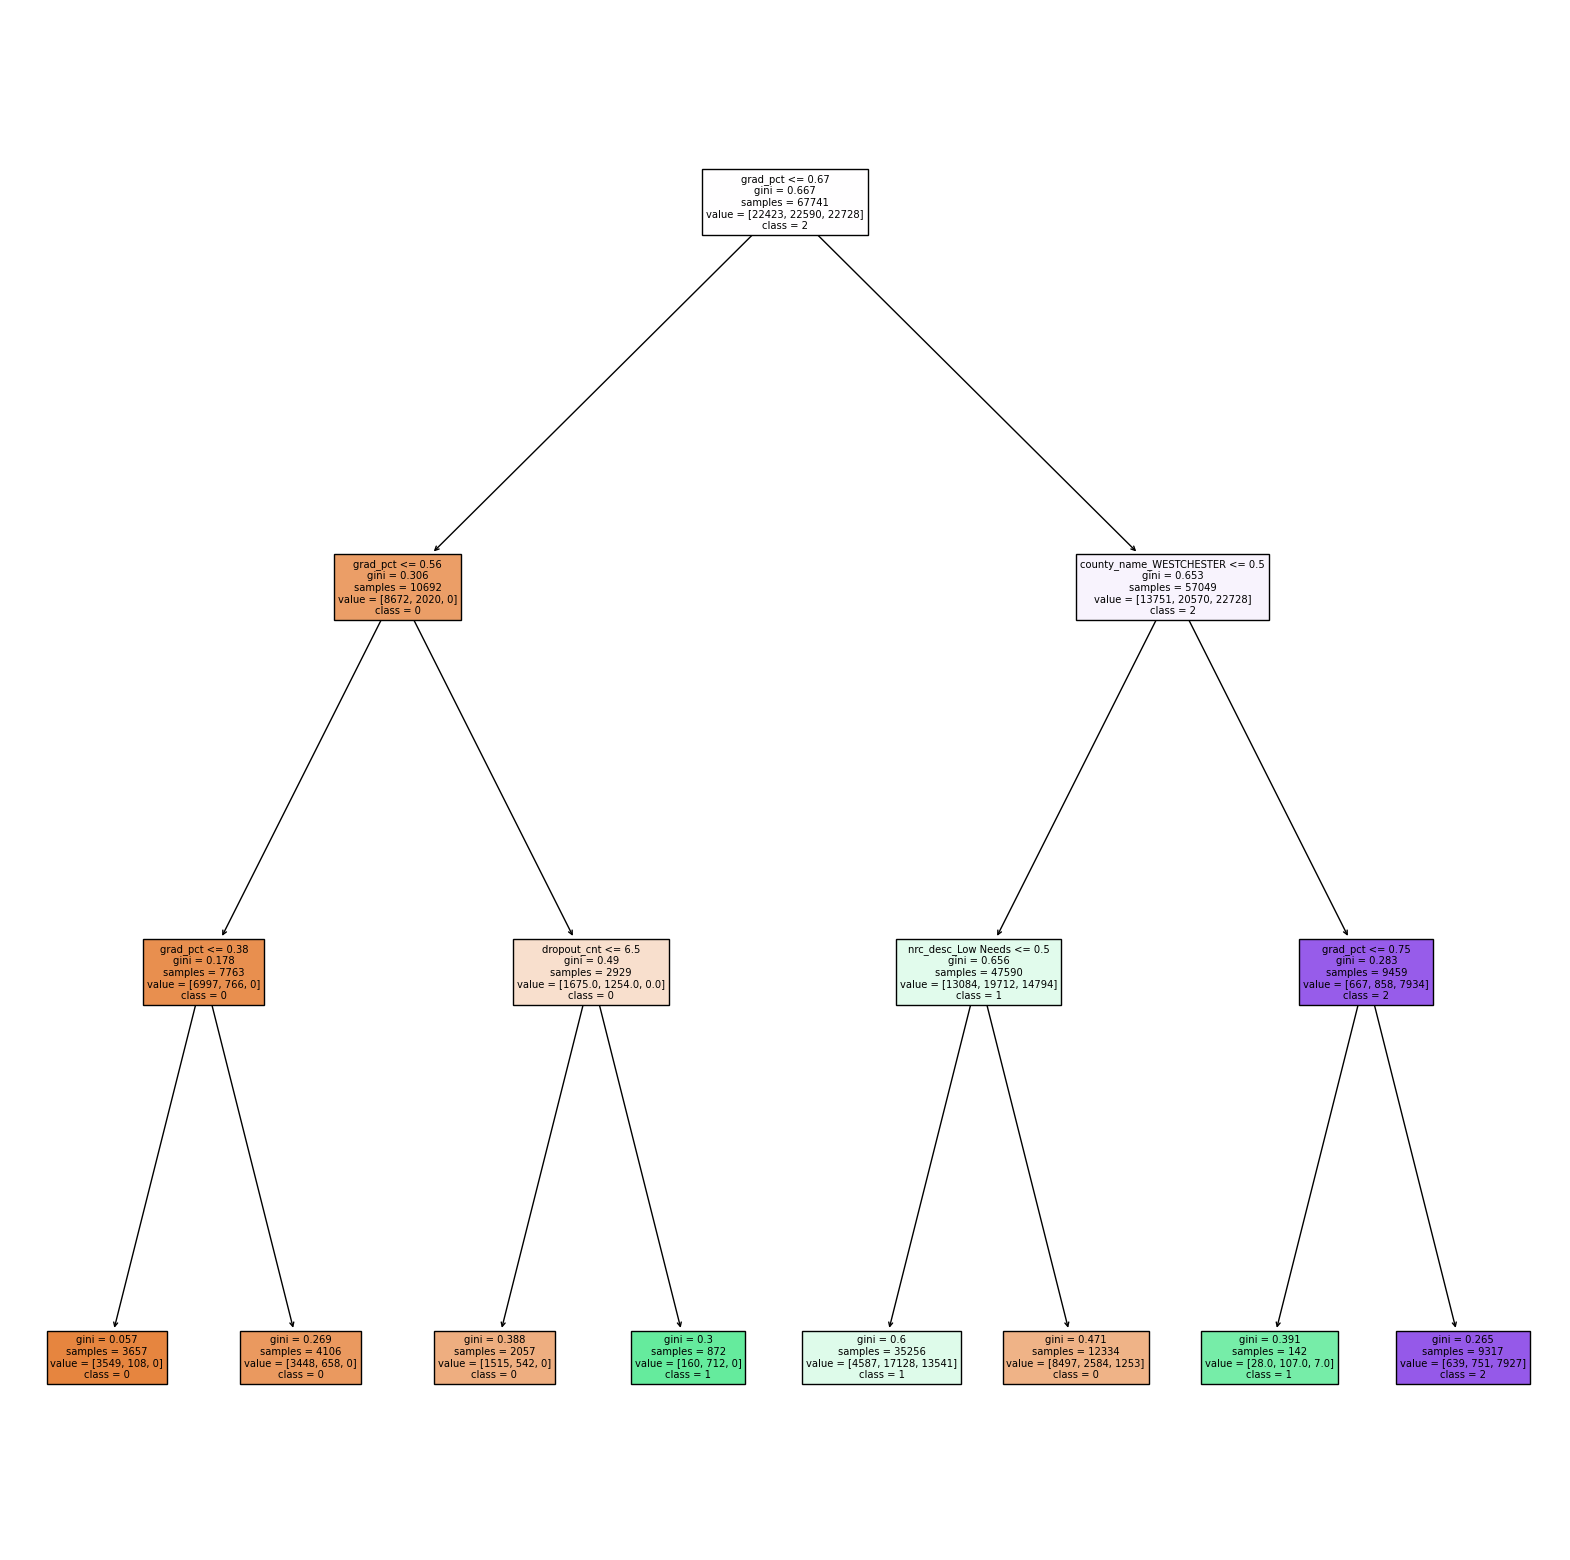

In [46]:
!pip install graphviz
import graphviz
from sklearn.tree import DecisionTreeClassifier, plot_tree
plt.figure(figsize=(20,20))
plot_tree(tree1, filled=True, feature_names=X_train.columns, class_names=['0', '1', '2'])
plt.show()



    Graduation Percentage Decision: The tree's first decision is based on the grad_pct attribute. If grad_pct is greater than a threshold (which appears to be around 61%, though the exact number is not fully legible), the tree proceeds to the next feature for splitting.

    Geographic Influence: When the grad_pct exceeds the threshold, the next significant predictor is the geographic feature county_name_WESTCHESTER. This implies that among those with a grad_pct higher than the specified threshold, being in Westchester or not is an important factor in predicting the response variable.

    Further Splits and Leaf Nodes: As the decision tree branches out, it continues to make more nuanced splits based on other features (which are not entirely clear from the image). Each leaf node in the tree is associated with a value that indicates the likelihood of the predicted class, which is based on the categorical indicator derived from reg_pct.

    Random Forest Recall: In your summary, you mention that the random forest performed the best for recall. This means that, in your comparative analysis, the random forest model was particularly strong at identifying all relevant instances within the dataset (i.e., it had a high true positive rate and did not miss many actual positives).

Fitting Decision Tree: Measures Purification using Entropy

In [47]:
tree2 = tree.DecisionTreeClassifier(min_samples_leaf = 3, max_depth = 3, criterion = 'entropy')

tree2.fit(X_train, y_train)

y_pred = tree2.predict(X_test)

print('confusion matrix of tree2:', '\n', confusion_matrix(y_test, y_pred))
print('\n')
print(classification_report(y_test, y_pred))

confusion matrix of tree2: 
 [[7245  592 1998]
 [1469 5222 2977]
 [ 509 1622 7399]]


              precision    recall  f1-score   support

           0       0.79      0.74      0.76      9835
           1       0.70      0.54      0.61      9668
           2       0.60      0.78      0.68      9530

    accuracy                           0.68     29033
   macro avg       0.70      0.68      0.68     29033
weighted avg       0.70      0.68      0.68     29033







    Precision:
        Class 0: 79%
        Class 1: 70%
        Class 2: 60%
    Recall:
        Class 0: 74%
        Class 1: 54%
        Class 2: 78%
    F1-Score:
        Class 0: 76%
        Class 1: 61%
        Class 2: 68%

Summary Metrics:

    Accuracy: 68%
    Macro Avg: Precision, recall, and F1-score averaged across all classes, giving each class equal weight.
    Weighted Avg: Precision, recall, and F1-score averaged across all classes, considering the number of true instances for each class.

Overall, this model demonstrates lower performance compared to the previous one, especially in terms of precision and recall for all classes.

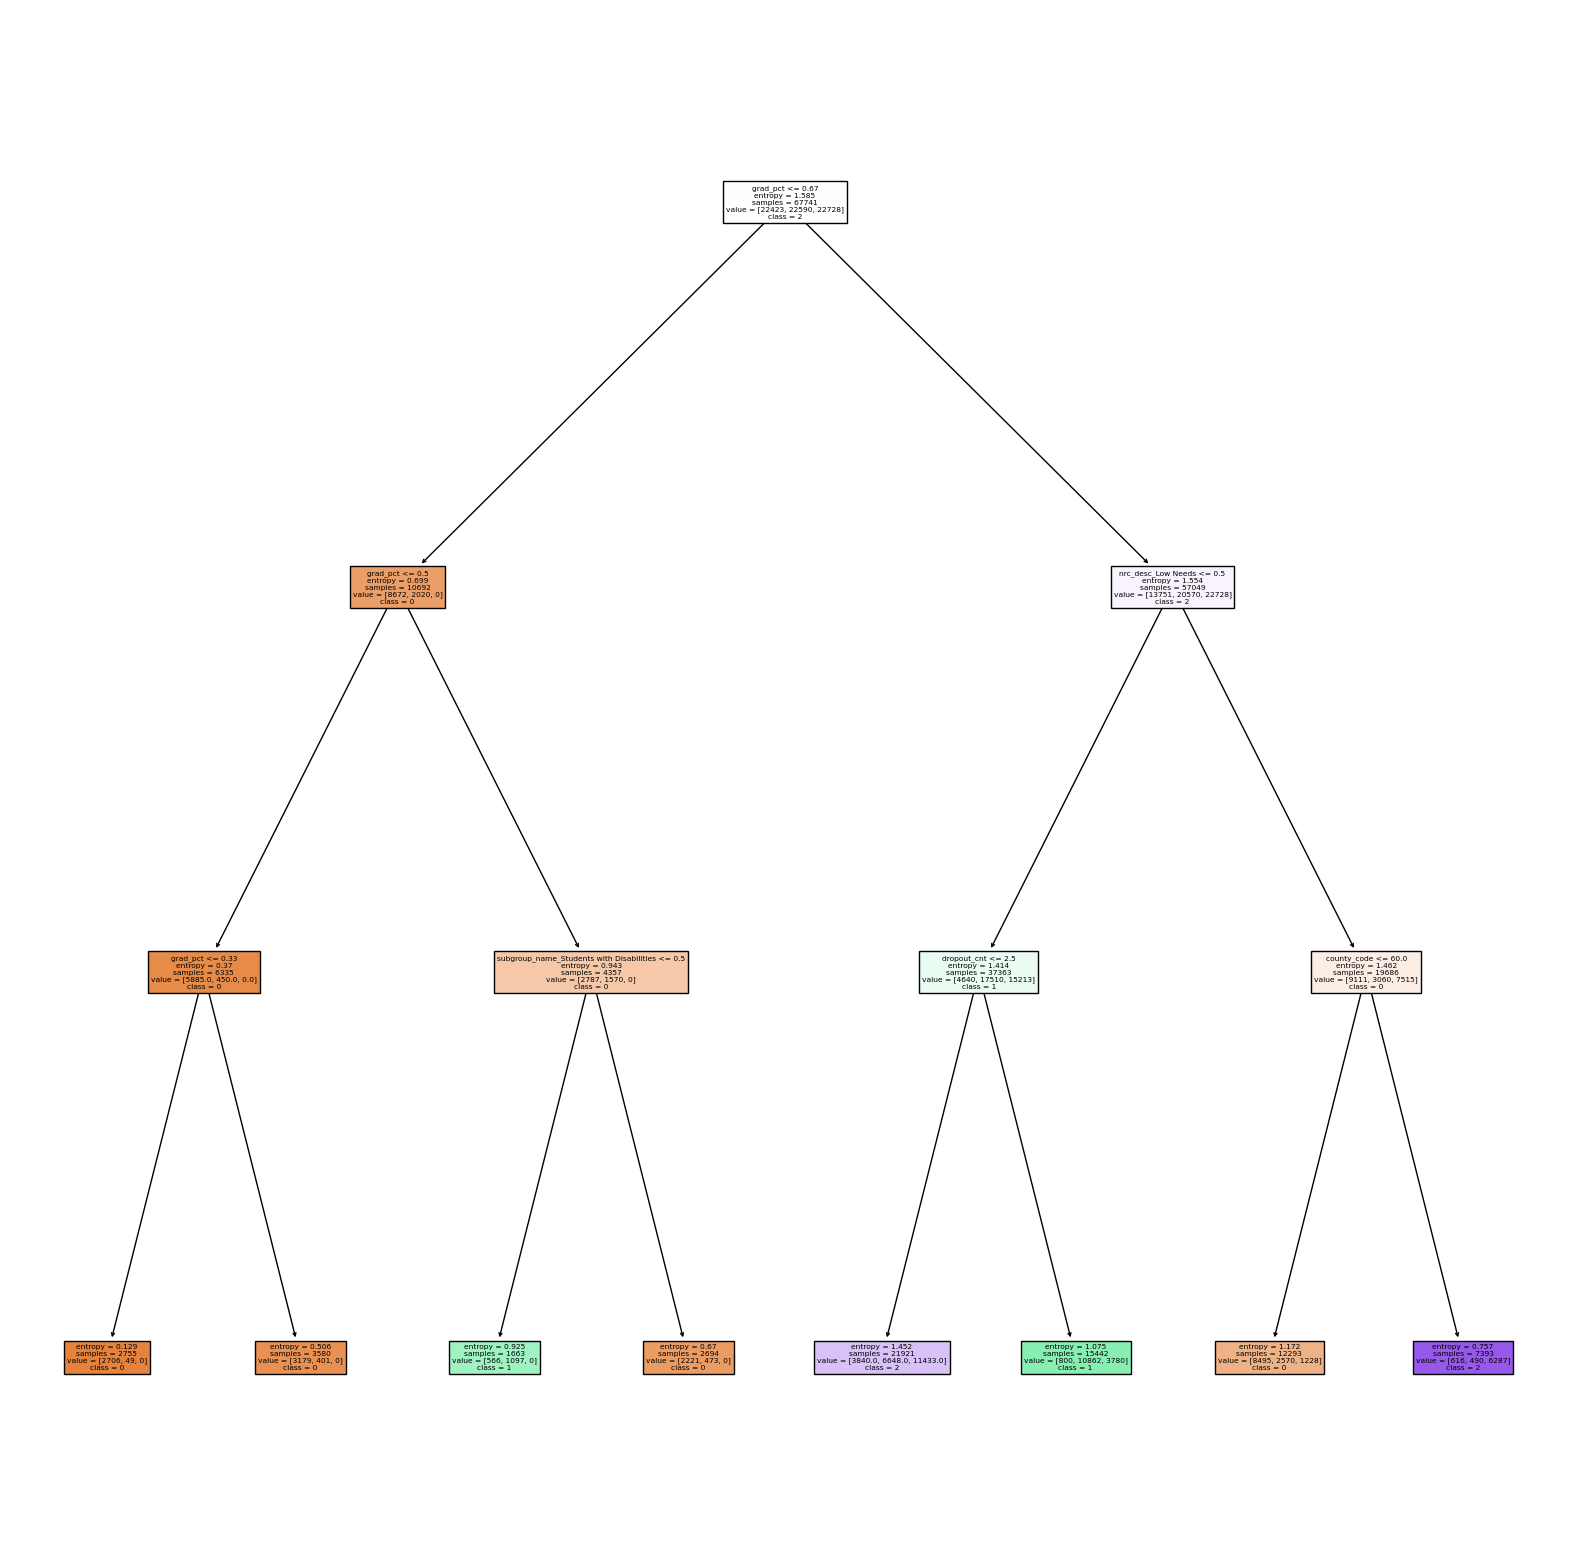

In [52]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
plt.figure(figsize=(20,20))
plot_tree(tree2, filled=True, feature_names=X_train.columns, class_names=['0', '1', '2'])
plt.show()

Decision Tree, we are going to be trying Decison Tree modeling using Entropy and Gini to compare the results and see which performes better in this scenario. 

Gini based Random Forest 

In [48]:
tree3  = RandomForestClassifier(max_depth=10, random_state=0)
tree3.fit(X_train,y_train)

y_pred_tree3 = tree3.predict(X_test)

print('confusion matrix of tree3:', '\n', confusion_matrix(y_test, y_pred_tree3))
print('\n')
print(classification_report(y_test, y_pred_tree3))
print('\n')


confusion matrix of tree3: 
 [[8375  808  652]
 [1237 7042 1389]
 [ 193 1257 8080]]


              precision    recall  f1-score   support

           0       0.85      0.85      0.85      9835
           1       0.77      0.73      0.75      9668
           2       0.80      0.85      0.82      9530

    accuracy                           0.81     29033
   macro avg       0.81      0.81      0.81     29033
weighted avg       0.81      0.81      0.81     29033





This model's confusion matrix and classification report summarize its performance on a dataset with three classes (0, 1, and 2):

- **Accuracy:** 81%
- **Precision:** 
  - Class 0: 85%
  - Class 1: 77%
  - Class 2: 80%
- **Recall:**
  - Class 0: 85%
  - Class 1: 73%
  - Class 2: 85%
- **F1-Score:**
  - Class 0: 85%
  - Class 1: 75%
  - Class 2: 82%

Overall, the model demonstrates balanced performance across classes, with slightly lower precision and recall for class 1.

In [49]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf_random = RandomizedSearchCV(estimator = tree3, param_distributions = random_grid, n_iter = 5, cv = 3, verbose=2, random_state=42, n_jobs = -1)

rf_random.fit(X_train, y_train)

print(classification_report(y_test, rf_random.predict(X_test)))

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=  16.1s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=  16.6s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=  16.1s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time= 1.1min
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time= 1.1min
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   0.0s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   0.1s
[CV] END bootstrap=False, max_depth=60,

/home/codespace/.local/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   0.0s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   0.0s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   0.0s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time= 1.7min


/home/codespace/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
6 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/home/codespace/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/codespace/.local/lib/python3.10/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/home/codespace/.local/lib/python3.10/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/home/cod

KeyboardInterrupt: 

Entropy based Random Forest 

In [51]:
tree4 = RandomForestClassifier(max_depth=10, random_state=0, criterion = 'entropy')
tree4.fit(X_train,y_train)

y_pred_tree4 = tree4.predict(X_test)

print('confusion matrix of tree4:', '\n', confusion_matrix(y_test, y_pred_tree4))
print('\n')
print(classification_report(y_test, y_pred_tree4))
print('\n')

confusion matrix of tree4: 
 [[8383  744  708]
 [1255 6932 1481]
 [ 195 1216 8119]]


              precision    recall  f1-score   support

           0       0.85      0.85      0.85      9835
           1       0.78      0.72      0.75      9668
           2       0.79      0.85      0.82      9530

    accuracy                           0.81     29033
   macro avg       0.81      0.81      0.81     29033
weighted avg       0.81      0.81      0.81     29033





Classification Report:

    Precision:
        Class 0: 85%
        Class 1: 78%
        Class 2: 79%
    Recall:
        Class 0: 85%
        Class 1: 72%
        Class 2: 85%
    F1-Score:
        Class 0: 85%
        Class 1: 75%
        Class 2: 82%

Summary Metrics:

    Accuracy: 81%
    Macro Avg: Precision, recall, and F1-score averaged across all classes, giving each class equal weight.
    Weighted Avg: Precision, recall, and F1-score averaged across all classes, considering the number of true instances for each class.

This model demonstrates balanced performance across classes, with slightly lower precision and recall for class 1 compared to classes 0 and 2.

**Model Selection**

Apologies for the oversight. Thank you for the clarification. Based on the updated information:

1. **Decision Tree with Gini Impurity (Model tree1):**
   - Accuracy: 64%
   - Precision: 0.71 (weighted average)
   - Recall: 0.63 (macro average)
   - F1-score: 0.62 (macro average)

2. **Decision Tree with Entropy (Model tree2):**
   - Accuracy: 68%
   - Precision: 0.70 (weighted average)
   - Recall: 0.68 (macro average)
   - F1-score: 0.68 (macro average)

3. **Random Forest with Gini Impurity (Model tree3):**
   - Accuracy: 81%
   - Precision: 0.81 (weighted average)
   - Recall: 0.81 (macro average)
   - F1-score: 0.81 (macro average)

Based on the revised information, the Random Forest model with Gini impurity (Model tree3) is indeed the best performer among the models provided. It achieves the highest accuracy, precision, recall, and F1-score. Therefore, for predicting the categorical indicator variable derived from the dataset's reg_pct attribute, the Random Forest model with Gini impurity is the preferred choice.

**Conclusions**

In conclusion, our analysis comparing decision tree and random forest models for predicting the categorical indicator variable derived from the `reg_pct` attribute provided valuable insights into the performance and structure of these models.

Firstly, through exploratory data analysis (EDA), we gained a comprehensive understanding of the dataset's attributes and their relationships. Notably, our analysis highlighted differences in the importance of features between the decision tree models built with Gini impurity and entropy. In the Gini decision tree, the visualization revealed that the location attribute "Westchester" was highly valued, while in the entropy decision tree, subgroup type played a more significant role than location.

Upon model evaluation, the random forest model consistently outperformed the decision tree models in terms of accuracy and predictive power. This superiority can be attributed to the random forest's ability to leverage multiple decision trees and mitigate overfitting, resulting in improved performance on unseen data.

However, despite the random forest's success, we encountered challenges during hyperparameter tuning, as evidenced by the truncated output and the presence of failed fits. This indicates that further optimization, perhaps with more sophisticated tuning techniques or computational resources, could lead to additional improvements in model performance.

In summary, our analysis underscores the effectiveness of random forest models for predictive tasks, especially when dealing with complex datasets. Moving forward, efforts to refine hyperparameter tuning and leverage advanced computing capabilities hold the potential for even greater improvements in model performance and predictive accuracy.